# Training of Random Forest classifiers

In the following, we compare the accuracy of different versions of the Rhapsody classifier, trained on the Integrated Dataset and evaluated through 10-fold cross-validation. 

More specifically, we considered:
* different subsets of features,
* different subsets of the training dataset,
* different classifier's hyperparameters

In [1]:
import sys, os
import pickle
import numpy as np
from glob import glob

In [2]:
# Insert here path to Rhapsody folder
sys.path.insert(0, '/home/lponzoni/Scratch/028-RHAPSODY-git/rhapsody') 

In [3]:
from rhapsody import *

## Importing the training dataset

The Integrated Dataset used for training is made available as a NumPy structured array containing all precomputed features, as well as true labels and other info (e.g. PDB lengths).

In [4]:
ID = pickle.load(open('Integrated_Dataset.pkl', 'rb'))

In [5]:
# array structure
ID.dtype.names

('SAV_coords',
 'Uniprot2PDB',
 'true_label',
 'ANM_MSF-chain',
 'ANM_MSF-reduced',
 'ANM_effectiveness-chain',
 'ANM_effectiveness-reduced',
 'ANM_sensitivity-chain',
 'ANM_sensitivity-reduced',
 'BLOSUM',
 'Delta_PSIC',
 'Delta_SASA',
 'EVmut-DeltaE_epist',
 'EVmut-DeltaE_epist_norm',
 'EVmut-DeltaE_epist_norm2',
 'EVmut-DeltaE_epist_rank',
 'EVmut-DeltaE_epist_rank2',
 'EVmut-DeltaE_indep',
 'EVmut-mut_aa_freq',
 'EVmut-wt_aa_cons',
 'GNM_MSF-chain',
 'GNM_MSF-reduced',
 'GNM_effectiveness-chain',
 'GNM_effectiveness-reduced',
 'GNM_sensitivity-chain',
 'GNM_sensitivity-reduced',
 'MBS-chain',
 'MBS-reduced',
 'PDB_length',
 'SASA',
 'entropy',
 'ranked_MI',
 'stiffness-chain',
 'stiffness-reduced',
 'wt_PSIC')

In [6]:
# each entry can be accessed by indexing
ID[0]

('Q96JB6 405 D A', 'Unable to map SAV to PDB', 0, nan, nan, nan, nan, nan, nan, -2., 2.234, nan, -6.859, 0.6333, 0.6333, 0.1053, 0.1053, -2.213, 0.07133, 0.5493, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.469, 0.9847, nan, nan, -0.924)

In [7]:
# size of the training dataset
len(ID)

92108

In [8]:
# number of entries with an associated PDB structure
len(ID[~np.isnan(ID['PDB_length'])])

28010

## Cross-validation with various classification schemes

We assess, through 10-fold cross-validation, the effect of considering different combinations of features and training datasets. 
In particular, we compare performances when using:
* different subsets of the training dataset, obtained by selecting those cases where PDB structures were larger than *n* residues
* 4 different feature sets, including one reproducing version 1 of the method (RAPSODY)
* **GNM** vs **ANM** features
* ENM features computed with and without the inclusion of *enviromental* effects (**reduced** vs **chain** model), i.e. the presence of other chains in the PDB structure


In [9]:
os.mkdir('RF_training')

In [10]:
# this cell requires ~3.5 hours to complete

CV_summaries = {}

if os.path.isfile('RF_training/CV-summaries.pkl'):
    print('A pickle containing precomputed training results have been found.')
    print('Please delete it if you wish to run the training again.')
else:
    for min_num_res in [0, 100, 150, 200, 300, 400, 500, 600]:
        # compute subset of the training dataset
        ID_subset = ID[ ~np.isnan(ID['PDB_length']) ]
        ID_subset = ID_subset[ ID_subset['PDB_length'] >= min_num_res ]
        
        # loop over different classification schemes
        for ENM in ['GNM', 'ANM']:
            for model in ['chain', 'reduced']:
                for version in ['v2', 'v2_noPfam', 'v2_EVmut', 'v1']:

                    # select feature set (+ true label)
                    if version == 'v2':
                        # full classifier
                        featset = ['true_label', 
                                   'wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'entropy', 'ranked_MI', 'BLOSUM']
                    elif version == 'v2_noPfam':
                        # reduced classifier
                        featset = ['true_label',
                                   'wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'BLOSUM']
                    elif version == 'v2_EVmut':
                        # full classifier + EVmutation epistatic score
                        featset = ['true_label',
                                   'wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'entropy', 'ranked_MI', 'BLOSUM',
                                   'EVmut-DeltaE_epist']
                    elif version == 'v1' and ENM == 'GNM' and model == 'chain':
                        # classifier as in version 1 of Rhapsody (RAPSODY)
                        # NB: RAPSODY used a combination of GNM/ANM features, which
                        # we reproduce here for the sake of comparison
                        featset = ['true_label', 
                                   'wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   'GNM_MSF-chain', 
                                   'ANM_effectiveness-chain', 
                                   'ANM_sensitivity-chain',
                                   'stiffness-chain']
                    else:
                        continue

                    if version == 'v1':
                        scheme = f'{min_num_res}-v1'
                    else:
                        scheme = f'{min_num_res}-{ENM}-{model}-{version}'
                    print(f'CLASSIFICATION SCHEME: {scheme}')                        

                    # create folder
                    folder = f'RF_training/clsf_scheme-{scheme}'
                    os.mkdir(folder)
                    
                    # train the classifier
                    clsf = trainRFclassifier(ID_subset[featset])

                    # store summary from cross-validation into a dictionary
                    CV_summaries[scheme] = clsf['CV summary']

                    # move figures into folder
                    for file in glob('*png'):
                        os.rename(file, os.path.join(folder, file))

                    # we'll only keep classifiers trained with the 150 min_num_res requirement
                    clsf_file = 'trained_classifier.pkl'
                    if min_num_res == 150:
                        os.rename(clsf_file, os.path.join(folder, clsf_file))
                    else:
                        os.remove(clsf_file)
                    
    # store all cross-validation results into a pickle
    pickle.dump(CV_summaries, open('RF_training/CV-summaries.pkl', 'wb'))

CLASSIFICATION SCHEME: 0-GNM-chain-v2


@> 5955 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.840   OOB score = 0.818
@> CV iteration # 2:    ROC-AUC = 0.852   OOB score = 0.817
@> CV iteration # 3:    ROC-AUC = 0.839   OOB score = 0.818
@> CV iteration # 4:    ROC-AUC = 0.828   OOB score = 0.819
@> CV iteration # 5:    ROC-AUC = 0.839   OOB score = 0.817
@> CV iteration # 6:    ROC-AUC = 0.847   OOB score = 0.819
@> CV iteration # 7:    ROC-AUC = 0.842   OOB score = 0.821
@> CV iteration # 8:    ROC-AUC = 0.845   OOB score = 0.817
@> CV iteration # 9:    ROC-AUC = 0.859   OOB score = 0.818
@> CV iteration #10:    ROC-AUC = 0.852   OOB score = 0.819
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   22055
@> mean ROC-AUC:            0.844
@> mean OOB score:          0.818
@> optimal cutoff*:         0.728 +/- 0.030
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.146
@>           

CLASSIFICATION SCHEME: 0-GNM-chain-v2_noPfam


@> 315 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.830   OOB score = 0.807
@> CV iteration # 2:    ROC-AUC = 0.817   OOB score = 0.806
@> CV iteration # 3:    ROC-AUC = 0.843   OOB score = 0.804
@> CV iteration # 4:    ROC-AUC = 0.821   OOB score = 0.805
@> CV iteration # 5:    ROC-AUC = 0.838   OOB score = 0.804
@> CV iteration # 6:    ROC-AUC = 0.824   OOB score = 0.806
@> CV iteration # 7:    ROC-AUC = 0.832   OOB score = 0.804
@> CV iteration # 8:    ROC-AUC = 0.846   OOB score = 0.803
@> CV iteration # 9:    ROC-AUC = 0.834   OOB score = 0.803
@> CV iteration #10:    ROC-AUC = 0.837   OOB score = 0.806
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   27695
@> mean ROC-AUC:            0.832
@> mean OOB score:          0.805
@> optimal cutoff*:         0.705 +/- 0.026
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.182
@>            

CLASSIFICATION SCHEME: 0-GNM-chain-v2_EVmut


@> 11472 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.858   OOB score = 0.844
@> CV iteration # 2:    ROC-AUC = 0.836   OOB score = 0.845
@> CV iteration # 3:    ROC-AUC = 0.861   OOB score = 0.843
@> CV iteration # 4:    ROC-AUC = 0.854   OOB score = 0.843
@> CV iteration # 5:    ROC-AUC = 0.841   OOB score = 0.844
@> CV iteration # 6:    ROC-AUC = 0.851   OOB score = 0.845
@> CV iteration # 7:    ROC-AUC = 0.856   OOB score = 0.845
@> CV iteration # 8:    ROC-AUC = 0.852   OOB score = 0.846
@> CV iteration # 9:    ROC-AUC = 0.845   OOB score = 0.843
@> CV iteration #10:    ROC-AUC = 0.862   OOB score = 0.844
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16538
@> mean ROC-AUC:            0.851
@> mean OOB score:          0.844
@> optimal cutoff*:         0.787 +/- 0.025
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.116
@>          

CLASSIFICATION SCHEME: 0-v1


@> 313 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.826   OOB score = 0.804
@> CV iteration # 2:    ROC-AUC = 0.836   OOB score = 0.802
@> CV iteration # 3:    ROC-AUC = 0.837   OOB score = 0.802
@> CV iteration # 4:    ROC-AUC = 0.835   OOB score = 0.803
@> CV iteration # 5:    ROC-AUC = 0.829   OOB score = 0.802
@> CV iteration # 6:    ROC-AUC = 0.835   OOB score = 0.801
@> CV iteration # 7:    ROC-AUC = 0.841   OOB score = 0.802
@> CV iteration # 8:    ROC-AUC = 0.827   OOB score = 0.802
@> CV iteration # 9:    ROC-AUC = 0.838   OOB score = 0.802
@> CV iteration #10:    ROC-AUC = 0.831   OOB score = 0.801
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   27697
@> mean ROC-AUC:            0.833
@> mean OOB score:          0.802
@> optimal cutoff*:         0.722 +/- 0.020
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.186
@>            

CLASSIFICATION SCHEME: 0-GNM-reduced-v2


@> 5978 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.844   OOB score = 0.813
@> CV iteration # 2:    ROC-AUC = 0.833   OOB score = 0.815
@> CV iteration # 3:    ROC-AUC = 0.852   OOB score = 0.815
@> CV iteration # 4:    ROC-AUC = 0.834   OOB score = 0.815
@> CV iteration # 5:    ROC-AUC = 0.842   OOB score = 0.814
@> CV iteration # 6:    ROC-AUC = 0.837   OOB score = 0.815
@> CV iteration # 7:    ROC-AUC = 0.833   OOB score = 0.816
@> CV iteration # 8:    ROC-AUC = 0.846   OOB score = 0.813
@> CV iteration # 9:    ROC-AUC = 0.840   OOB score = 0.815
@> CV iteration #10:    ROC-AUC = 0.852   OOB score = 0.812
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   22032
@> mean ROC-AUC:            0.841
@> mean OOB score:          0.814
@> optimal cutoff*:         0.726 +/- 0.031
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.149
@>           

CLASSIFICATION SCHEME: 0-GNM-reduced-v2_noPfam


@> 348 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.813   OOB score = 0.802
@> CV iteration # 2:    ROC-AUC = 0.813   OOB score = 0.802
@> CV iteration # 3:    ROC-AUC = 0.830   OOB score = 0.800
@> CV iteration # 4:    ROC-AUC = 0.825   OOB score = 0.802
@> CV iteration # 5:    ROC-AUC = 0.827   OOB score = 0.801
@> CV iteration # 6:    ROC-AUC = 0.835   OOB score = 0.801
@> CV iteration # 7:    ROC-AUC = 0.825   OOB score = 0.801
@> CV iteration # 8:    ROC-AUC = 0.836   OOB score = 0.800
@> CV iteration # 9:    ROC-AUC = 0.827   OOB score = 0.800
@> CV iteration #10:    ROC-AUC = 0.824   OOB score = 0.800
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   27662
@> mean ROC-AUC:            0.825
@> mean OOB score:          0.801
@> optimal cutoff*:         0.707 +/- 0.047
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.184
@>            

CLASSIFICATION SCHEME: 0-GNM-reduced-v2_EVmut


@> 11472 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.846   OOB score = 0.841
@> CV iteration # 2:    ROC-AUC = 0.838   OOB score = 0.841
@> CV iteration # 3:    ROC-AUC = 0.841   OOB score = 0.842
@> CV iteration # 4:    ROC-AUC = 0.854   OOB score = 0.842
@> CV iteration # 5:    ROC-AUC = 0.849   OOB score = 0.844
@> CV iteration # 6:    ROC-AUC = 0.841   OOB score = 0.841
@> CV iteration # 7:    ROC-AUC = 0.842   OOB score = 0.842
@> CV iteration # 8:    ROC-AUC = 0.843   OOB score = 0.843
@> CV iteration # 9:    ROC-AUC = 0.850   OOB score = 0.843
@> CV iteration #10:    ROC-AUC = 0.861   OOB score = 0.842
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16538
@> mean ROC-AUC:            0.846
@> mean OOB score:          0.842
@> optimal cutoff*:         0.778 +/- 0.038
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.118
@>          

CLASSIFICATION SCHEME: 0-ANM-chain-v2


@> 5953 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.831   OOB score = 0.819
@> CV iteration # 2:    ROC-AUC = 0.854   OOB score = 0.816
@> CV iteration # 3:    ROC-AUC = 0.846   OOB score = 0.816
@> CV iteration # 4:    ROC-AUC = 0.844   OOB score = 0.818
@> CV iteration # 5:    ROC-AUC = 0.837   OOB score = 0.818
@> CV iteration # 6:    ROC-AUC = 0.840   OOB score = 0.819
@> CV iteration # 7:    ROC-AUC = 0.848   OOB score = 0.818
@> CV iteration # 8:    ROC-AUC = 0.838   OOB score = 0.817
@> CV iteration # 9:    ROC-AUC = 0.849   OOB score = 0.819
@> CV iteration #10:    ROC-AUC = 0.853   OOB score = 0.817
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   22057
@> mean ROC-AUC:            0.844
@> mean OOB score:          0.818
@> optimal cutoff*:         0.750 +/- 0.023
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.147
@>           

CLASSIFICATION SCHEME: 0-ANM-chain-v2_noPfam


@> 313 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.827   OOB score = 0.805
@> CV iteration # 2:    ROC-AUC = 0.834   OOB score = 0.804
@> CV iteration # 3:    ROC-AUC = 0.839   OOB score = 0.804
@> CV iteration # 4:    ROC-AUC = 0.833   OOB score = 0.803
@> CV iteration # 5:    ROC-AUC = 0.823   OOB score = 0.804
@> CV iteration # 6:    ROC-AUC = 0.832   OOB score = 0.804
@> CV iteration # 7:    ROC-AUC = 0.836   OOB score = 0.804
@> CV iteration # 8:    ROC-AUC = 0.822   OOB score = 0.803
@> CV iteration # 9:    ROC-AUC = 0.834   OOB score = 0.803
@> CV iteration #10:    ROC-AUC = 0.836   OOB score = 0.802
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   27697
@> mean ROC-AUC:            0.831
@> mean OOB score:          0.804
@> optimal cutoff*:         0.724 +/- 0.026
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.181
@>            

CLASSIFICATION SCHEME: 0-ANM-chain-v2_EVmut


@> 11470 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.852   OOB score = 0.846
@> CV iteration # 2:    ROC-AUC = 0.836   OOB score = 0.846
@> CV iteration # 3:    ROC-AUC = 0.857   OOB score = 0.845
@> CV iteration # 4:    ROC-AUC = 0.850   OOB score = 0.845
@> CV iteration # 5:    ROC-AUC = 0.851   OOB score = 0.846
@> CV iteration # 6:    ROC-AUC = 0.860   OOB score = 0.844
@> CV iteration # 7:    ROC-AUC = 0.866   OOB score = 0.845
@> CV iteration # 8:    ROC-AUC = 0.848   OOB score = 0.846
@> CV iteration # 9:    ROC-AUC = 0.852   OOB score = 0.846
@> CV iteration #10:    ROC-AUC = 0.854   OOB score = 0.847
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16540
@> mean ROC-AUC:            0.853
@> mean OOB score:          0.846
@> optimal cutoff*:         0.772 +/- 0.038
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.116
@>          

CLASSIFICATION SCHEME: 0-ANM-reduced-v2


@> 5978 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.839   OOB score = 0.815
@> CV iteration # 2:    ROC-AUC = 0.837   OOB score = 0.815
@> CV iteration # 3:    ROC-AUC = 0.850   OOB score = 0.815
@> CV iteration # 4:    ROC-AUC = 0.837   OOB score = 0.815
@> CV iteration # 5:    ROC-AUC = 0.847   OOB score = 0.813
@> CV iteration # 6:    ROC-AUC = 0.842   OOB score = 0.814
@> CV iteration # 7:    ROC-AUC = 0.830   OOB score = 0.816
@> CV iteration # 8:    ROC-AUC = 0.852   OOB score = 0.813
@> CV iteration # 9:    ROC-AUC = 0.840   OOB score = 0.813
@> CV iteration #10:    ROC-AUC = 0.855   OOB score = 0.812
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   22032
@> mean ROC-AUC:            0.842
@> mean OOB score:          0.814
@> optimal cutoff*:         0.726 +/- 0.027
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.150
@>           

CLASSIFICATION SCHEME: 0-ANM-reduced-v2_noPfam


@> 348 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.820   OOB score = 0.802
@> CV iteration # 2:    ROC-AUC = 0.810   OOB score = 0.804
@> CV iteration # 3:    ROC-AUC = 0.839   OOB score = 0.801
@> CV iteration # 4:    ROC-AUC = 0.826   OOB score = 0.803
@> CV iteration # 5:    ROC-AUC = 0.831   OOB score = 0.802
@> CV iteration # 6:    ROC-AUC = 0.835   OOB score = 0.801
@> CV iteration # 7:    ROC-AUC = 0.830   OOB score = 0.802
@> CV iteration # 8:    ROC-AUC = 0.841   OOB score = 0.801
@> CV iteration # 9:    ROC-AUC = 0.832   OOB score = 0.801
@> CV iteration #10:    ROC-AUC = 0.825   OOB score = 0.801
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   27662
@> mean ROC-AUC:            0.829
@> mean OOB score:          0.802
@> optimal cutoff*:         0.703 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.184
@>            

CLASSIFICATION SCHEME: 0-ANM-reduced-v2_EVmut


@> 11472 out of 28010 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.847   OOB score = 0.841
@> CV iteration # 2:    ROC-AUC = 0.834   OOB score = 0.842
@> CV iteration # 3:    ROC-AUC = 0.843   OOB score = 0.841
@> CV iteration # 4:    ROC-AUC = 0.857   OOB score = 0.840
@> CV iteration # 5:    ROC-AUC = 0.848   OOB score = 0.844
@> CV iteration # 6:    ROC-AUC = 0.841   OOB score = 0.841
@> CV iteration # 7:    ROC-AUC = 0.835   OOB score = 0.843
@> CV iteration # 8:    ROC-AUC = 0.839   OOB score = 0.843
@> CV iteration # 9:    ROC-AUC = 0.852   OOB score = 0.841
@> CV iteration #10:    ROC-AUC = 0.865   OOB score = 0.841
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16538
@> mean ROC-AUC:            0.846
@> mean OOB score:          0.842
@> optimal cutoff*:         0.794 +/- 0.024
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.119
@>          

CLASSIFICATION SCHEME: 100-GNM-chain-v2


@> 5048 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.829   OOB score = 0.821
@> CV iteration # 2:    ROC-AUC = 0.822   OOB score = 0.820
@> CV iteration # 3:    ROC-AUC = 0.854   OOB score = 0.820
@> CV iteration # 4:    ROC-AUC = 0.855   OOB score = 0.819
@> CV iteration # 5:    ROC-AUC = 0.845   OOB score = 0.820
@> CV iteration # 6:    ROC-AUC = 0.852   OOB score = 0.819
@> CV iteration # 7:    ROC-AUC = 0.853   OOB score = 0.818
@> CV iteration # 8:    ROC-AUC = 0.845   OOB score = 0.821
@> CV iteration # 9:    ROC-AUC = 0.840   OOB score = 0.820
@> CV iteration #10:    ROC-AUC = 0.875   OOB score = 0.818
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20524
@> mean ROC-AUC:            0.847
@> mean OOB score:          0.820
@> optimal cutoff*:         0.727 +/- 0.024
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.149
@>           

CLASSIFICATION SCHEME: 100-GNM-chain-v2_noPfam


@> 210 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.841   OOB score = 0.806
@> CV iteration # 2:    ROC-AUC = 0.833   OOB score = 0.806
@> CV iteration # 3:    ROC-AUC = 0.820   OOB score = 0.809
@> CV iteration # 4:    ROC-AUC = 0.850   OOB score = 0.806
@> CV iteration # 5:    ROC-AUC = 0.831   OOB score = 0.807
@> CV iteration # 6:    ROC-AUC = 0.813   OOB score = 0.807
@> CV iteration # 7:    ROC-AUC = 0.837   OOB score = 0.806
@> CV iteration # 8:    ROC-AUC = 0.847   OOB score = 0.806
@> CV iteration # 9:    ROC-AUC = 0.839   OOB score = 0.807
@> CV iteration #10:    ROC-AUC = 0.832   OOB score = 0.806
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   25362
@> mean ROC-AUC:            0.834
@> mean OOB score:          0.806
@> optimal cutoff*:         0.716 +/- 0.027
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.187
@>            

CLASSIFICATION SCHEME: 100-GNM-chain-v2_EVmut


@> 10039 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.826   OOB score = 0.846
@> CV iteration # 2:    ROC-AUC = 0.861   OOB score = 0.845
@> CV iteration # 3:    ROC-AUC = 0.849   OOB score = 0.844
@> CV iteration # 4:    ROC-AUC = 0.854   OOB score = 0.844
@> CV iteration # 5:    ROC-AUC = 0.847   OOB score = 0.845
@> CV iteration # 6:    ROC-AUC = 0.847   OOB score = 0.846
@> CV iteration # 7:    ROC-AUC = 0.859   OOB score = 0.843
@> CV iteration # 8:    ROC-AUC = 0.865   OOB score = 0.844
@> CV iteration # 9:    ROC-AUC = 0.838   OOB score = 0.845
@> CV iteration #10:    ROC-AUC = 0.852   OOB score = 0.847
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   15533
@> mean ROC-AUC:            0.850
@> mean OOB score:          0.845
@> optimal cutoff*:         0.800 +/- 0.023
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.118
@>          

CLASSIFICATION SCHEME: 100-v1


@> 208 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.836   OOB score = 0.801
@> CV iteration # 2:    ROC-AUC = 0.833   OOB score = 0.803
@> CV iteration # 3:    ROC-AUC = 0.836   OOB score = 0.802
@> CV iteration # 4:    ROC-AUC = 0.857   OOB score = 0.799
@> CV iteration # 5:    ROC-AUC = 0.832   OOB score = 0.803
@> CV iteration # 6:    ROC-AUC = 0.826   OOB score = 0.804
@> CV iteration # 7:    ROC-AUC = 0.830   OOB score = 0.803
@> CV iteration # 8:    ROC-AUC = 0.838   OOB score = 0.803
@> CV iteration # 9:    ROC-AUC = 0.839   OOB score = 0.802
@> CV iteration #10:    ROC-AUC = 0.833   OOB score = 0.804
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   25364
@> mean ROC-AUC:            0.836
@> mean OOB score:          0.803
@> optimal cutoff*:         0.720 +/- 0.037
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.191
@>            

CLASSIFICATION SCHEME: 100-GNM-reduced-v2


@> 5071 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.842   OOB score = 0.816
@> CV iteration # 2:    ROC-AUC = 0.838   OOB score = 0.817
@> CV iteration # 3:    ROC-AUC = 0.865   OOB score = 0.816
@> CV iteration # 4:    ROC-AUC = 0.838   OOB score = 0.818
@> CV iteration # 5:    ROC-AUC = 0.824   OOB score = 0.817
@> CV iteration # 6:    ROC-AUC = 0.826   OOB score = 0.817
@> CV iteration # 7:    ROC-AUC = 0.831   OOB score = 0.817
@> CV iteration # 8:    ROC-AUC = 0.853   OOB score = 0.816
@> CV iteration # 9:    ROC-AUC = 0.856   OOB score = 0.817
@> CV iteration #10:    ROC-AUC = 0.841   OOB score = 0.817
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20501
@> mean ROC-AUC:            0.841
@> mean OOB score:          0.817
@> optimal cutoff*:         0.727 +/- 0.031
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.152
@>           

CLASSIFICATION SCHEME: 100-GNM-reduced-v2_noPfam


@> 243 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.832   OOB score = 0.802
@> CV iteration # 2:    ROC-AUC = 0.829   OOB score = 0.804
@> CV iteration # 3:    ROC-AUC = 0.826   OOB score = 0.803
@> CV iteration # 4:    ROC-AUC = 0.829   OOB score = 0.802
@> CV iteration # 5:    ROC-AUC = 0.843   OOB score = 0.801
@> CV iteration # 6:    ROC-AUC = 0.811   OOB score = 0.802
@> CV iteration # 7:    ROC-AUC = 0.816   OOB score = 0.803
@> CV iteration # 8:    ROC-AUC = 0.813   OOB score = 0.802
@> CV iteration # 9:    ROC-AUC = 0.835   OOB score = 0.802
@> CV iteration #10:    ROC-AUC = 0.831   OOB score = 0.803
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   25329
@> mean ROC-AUC:            0.826
@> mean OOB score:          0.802
@> optimal cutoff*:         0.703 +/- 0.028
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.189
@>            

CLASSIFICATION SCHEME: 100-GNM-reduced-v2_EVmut


@> 10039 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.850   OOB score = 0.843
@> CV iteration # 2:    ROC-AUC = 0.837   OOB score = 0.842
@> CV iteration # 3:    ROC-AUC = 0.861   OOB score = 0.844
@> CV iteration # 4:    ROC-AUC = 0.854   OOB score = 0.843
@> CV iteration # 5:    ROC-AUC = 0.849   OOB score = 0.842
@> CV iteration # 6:    ROC-AUC = 0.850   OOB score = 0.844
@> CV iteration # 7:    ROC-AUC = 0.854   OOB score = 0.842
@> CV iteration # 8:    ROC-AUC = 0.830   OOB score = 0.843
@> CV iteration # 9:    ROC-AUC = 0.827   OOB score = 0.844
@> CV iteration #10:    ROC-AUC = 0.834   OOB score = 0.844
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   15533
@> mean ROC-AUC:            0.844
@> mean OOB score:          0.843
@> optimal cutoff*:         0.759 +/- 0.025
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.120
@>          

CLASSIFICATION SCHEME: 100-ANM-chain-v2


@> 5046 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.833   OOB score = 0.822
@> CV iteration # 2:    ROC-AUC = 0.850   OOB score = 0.819
@> CV iteration # 3:    ROC-AUC = 0.857   OOB score = 0.820
@> CV iteration # 4:    ROC-AUC = 0.846   OOB score = 0.821
@> CV iteration # 5:    ROC-AUC = 0.834   OOB score = 0.820
@> CV iteration # 6:    ROC-AUC = 0.842   OOB score = 0.820
@> CV iteration # 7:    ROC-AUC = 0.858   OOB score = 0.818
@> CV iteration # 8:    ROC-AUC = 0.847   OOB score = 0.819
@> CV iteration # 9:    ROC-AUC = 0.850   OOB score = 0.820
@> CV iteration #10:    ROC-AUC = 0.853   OOB score = 0.820
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20526
@> mean ROC-AUC:            0.847
@> mean OOB score:          0.820
@> optimal cutoff*:         0.742 +/- 0.026
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.150
@>           

CLASSIFICATION SCHEME: 100-ANM-chain-v2_noPfam


@> 208 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.830   OOB score = 0.805
@> CV iteration # 2:    ROC-AUC = 0.834   OOB score = 0.805
@> CV iteration # 3:    ROC-AUC = 0.830   OOB score = 0.804
@> CV iteration # 4:    ROC-AUC = 0.854   OOB score = 0.802
@> CV iteration # 5:    ROC-AUC = 0.831   OOB score = 0.804
@> CV iteration # 6:    ROC-AUC = 0.831   OOB score = 0.805
@> CV iteration # 7:    ROC-AUC = 0.827   OOB score = 0.805
@> CV iteration # 8:    ROC-AUC = 0.835   OOB score = 0.803
@> CV iteration # 9:    ROC-AUC = 0.834   OOB score = 0.805
@> CV iteration #10:    ROC-AUC = 0.841   OOB score = 0.805
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   25364
@> mean ROC-AUC:            0.835
@> mean OOB score:          0.804
@> optimal cutoff*:         0.718 +/- 0.028
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.186
@>            

CLASSIFICATION SCHEME: 100-ANM-chain-v2_EVmut


@> 10037 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.835   OOB score = 0.847
@> CV iteration # 2:    ROC-AUC = 0.863   OOB score = 0.844
@> CV iteration # 3:    ROC-AUC = 0.844   OOB score = 0.848
@> CV iteration # 4:    ROC-AUC = 0.846   OOB score = 0.845
@> CV iteration # 5:    ROC-AUC = 0.844   OOB score = 0.847
@> CV iteration # 6:    ROC-AUC = 0.849   OOB score = 0.845
@> CV iteration # 7:    ROC-AUC = 0.866   OOB score = 0.845
@> CV iteration # 8:    ROC-AUC = 0.864   OOB score = 0.846
@> CV iteration # 9:    ROC-AUC = 0.849   OOB score = 0.848
@> CV iteration #10:    ROC-AUC = 0.865   OOB score = 0.845
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   15535
@> mean ROC-AUC:            0.852
@> mean OOB score:          0.846
@> optimal cutoff*:         0.795 +/- 0.030
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.118
@>          

CLASSIFICATION SCHEME: 100-ANM-reduced-v2


@> 5071 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.844   OOB score = 0.814
@> CV iteration # 2:    ROC-AUC = 0.837   OOB score = 0.816
@> CV iteration # 3:    ROC-AUC = 0.866   OOB score = 0.814
@> CV iteration # 4:    ROC-AUC = 0.844   OOB score = 0.817
@> CV iteration # 5:    ROC-AUC = 0.835   OOB score = 0.816
@> CV iteration # 6:    ROC-AUC = 0.825   OOB score = 0.817
@> CV iteration # 7:    ROC-AUC = 0.836   OOB score = 0.817
@> CV iteration # 8:    ROC-AUC = 0.855   OOB score = 0.815
@> CV iteration # 9:    ROC-AUC = 0.861   OOB score = 0.817
@> CV iteration #10:    ROC-AUC = 0.840   OOB score = 0.815
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20501
@> mean ROC-AUC:            0.844
@> mean OOB score:          0.816
@> optimal cutoff*:         0.719 +/- 0.031
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.153
@>           

CLASSIFICATION SCHEME: 100-ANM-reduced-v2_noPfam


@> 243 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.843   OOB score = 0.801
@> CV iteration # 2:    ROC-AUC = 0.831   OOB score = 0.803
@> CV iteration # 3:    ROC-AUC = 0.828   OOB score = 0.802
@> CV iteration # 4:    ROC-AUC = 0.830   OOB score = 0.804
@> CV iteration # 5:    ROC-AUC = 0.846   OOB score = 0.801
@> CV iteration # 6:    ROC-AUC = 0.822   OOB score = 0.803
@> CV iteration # 7:    ROC-AUC = 0.819   OOB score = 0.803
@> CV iteration # 8:    ROC-AUC = 0.823   OOB score = 0.803
@> CV iteration # 9:    ROC-AUC = 0.843   OOB score = 0.804
@> CV iteration #10:    ROC-AUC = 0.832   OOB score = 0.804
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   25329
@> mean ROC-AUC:            0.832
@> mean OOB score:          0.803
@> optimal cutoff*:         0.704 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.190
@>            

CLASSIFICATION SCHEME: 100-ANM-reduced-v2_EVmut


@> 10039 out of 25572 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.850   OOB score = 0.844
@> CV iteration # 2:    ROC-AUC = 0.835   OOB score = 0.843
@> CV iteration # 3:    ROC-AUC = 0.860   OOB score = 0.842
@> CV iteration # 4:    ROC-AUC = 0.852   OOB score = 0.843
@> CV iteration # 5:    ROC-AUC = 0.853   OOB score = 0.844
@> CV iteration # 6:    ROC-AUC = 0.853   OOB score = 0.844
@> CV iteration # 7:    ROC-AUC = 0.852   OOB score = 0.841
@> CV iteration # 8:    ROC-AUC = 0.836   OOB score = 0.843
@> CV iteration # 9:    ROC-AUC = 0.831   OOB score = 0.844
@> CV iteration #10:    ROC-AUC = 0.840   OOB score = 0.844
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   15533
@> mean ROC-AUC:            0.846
@> mean OOB score:          0.843
@> optimal cutoff*:         0.782 +/- 0.031
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.120
@>          

CLASSIFICATION SCHEME: 150-GNM-chain-v2


@> 4587 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.853   OOB score = 0.822
@> CV iteration # 2:    ROC-AUC = 0.856   OOB score = 0.824
@> CV iteration # 3:    ROC-AUC = 0.847   OOB score = 0.823
@> CV iteration # 4:    ROC-AUC = 0.863   OOB score = 0.823
@> CV iteration # 5:    ROC-AUC = 0.844   OOB score = 0.824
@> CV iteration # 6:    ROC-AUC = 0.852   OOB score = 0.822
@> CV iteration # 7:    ROC-AUC = 0.862   OOB score = 0.822
@> CV iteration # 8:    ROC-AUC = 0.845   OOB score = 0.823
@> CV iteration # 9:    ROC-AUC = 0.840   OOB score = 0.825
@> CV iteration #10:    ROC-AUC = 0.843   OOB score = 0.826
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   18800
@> mean ROC-AUC:            0.850
@> mean OOB score:          0.824
@> optimal cutoff*:         0.729 +/- 0.030
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.152
@>           

CLASSIFICATION SCHEME: 150-GNM-chain-v2_noPfam


@> 207 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.844   OOB score = 0.807
@> CV iteration # 2:    ROC-AUC = 0.841   OOB score = 0.809
@> CV iteration # 3:    ROC-AUC = 0.818   OOB score = 0.811
@> CV iteration # 4:    ROC-AUC = 0.832   OOB score = 0.810
@> CV iteration # 5:    ROC-AUC = 0.827   OOB score = 0.808
@> CV iteration # 6:    ROC-AUC = 0.838   OOB score = 0.810
@> CV iteration # 7:    ROC-AUC = 0.836   OOB score = 0.810
@> CV iteration # 8:    ROC-AUC = 0.827   OOB score = 0.810
@> CV iteration # 9:    ROC-AUC = 0.839   OOB score = 0.809
@> CV iteration #10:    ROC-AUC = 0.848   OOB score = 0.809
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   23180
@> mean ROC-AUC:            0.835
@> mean OOB score:          0.809
@> optimal cutoff*:         0.713 +/- 0.021
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.188
@>            

CLASSIFICATION SCHEME: 150-GNM-chain-v2_EVmut


@> 8914 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.853   OOB score = 0.850
@> CV iteration # 2:    ROC-AUC = 0.873   OOB score = 0.846
@> CV iteration # 3:    ROC-AUC = 0.853   OOB score = 0.847
@> CV iteration # 4:    ROC-AUC = 0.842   OOB score = 0.849
@> CV iteration # 5:    ROC-AUC = 0.863   OOB score = 0.847
@> CV iteration # 6:    ROC-AUC = 0.852   OOB score = 0.849
@> CV iteration # 7:    ROC-AUC = 0.866   OOB score = 0.848
@> CV iteration # 8:    ROC-AUC = 0.869   OOB score = 0.846
@> CV iteration # 9:    ROC-AUC = 0.818   OOB score = 0.850
@> CV iteration #10:    ROC-AUC = 0.842   OOB score = 0.848
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14473
@> mean ROC-AUC:            0.853
@> mean OOB score:          0.848
@> optimal cutoff*:         0.786 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.120
@>           

CLASSIFICATION SCHEME: 150-v1


@> 207 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.854   OOB score = 0.806
@> CV iteration # 2:    ROC-AUC = 0.838   OOB score = 0.804
@> CV iteration # 3:    ROC-AUC = 0.826   OOB score = 0.809
@> CV iteration # 4:    ROC-AUC = 0.838   OOB score = 0.807
@> CV iteration # 5:    ROC-AUC = 0.827   OOB score = 0.806
@> CV iteration # 6:    ROC-AUC = 0.848   OOB score = 0.807
@> CV iteration # 7:    ROC-AUC = 0.838   OOB score = 0.805
@> CV iteration # 8:    ROC-AUC = 0.829   OOB score = 0.807
@> CV iteration # 9:    ROC-AUC = 0.839   OOB score = 0.808
@> CV iteration #10:    ROC-AUC = 0.845   OOB score = 0.805
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   23180
@> mean ROC-AUC:            0.838
@> mean OOB score:          0.807
@> optimal cutoff*:         0.709 +/- 0.028
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.192
@>            

CLASSIFICATION SCHEME: 150-GNM-reduced-v2


@> 4612 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.835   OOB score = 0.821
@> CV iteration # 2:    ROC-AUC = 0.843   OOB score = 0.822
@> CV iteration # 3:    ROC-AUC = 0.847   OOB score = 0.819
@> CV iteration # 4:    ROC-AUC = 0.857   OOB score = 0.821
@> CV iteration # 5:    ROC-AUC = 0.854   OOB score = 0.819
@> CV iteration # 6:    ROC-AUC = 0.848   OOB score = 0.821
@> CV iteration # 7:    ROC-AUC = 0.839   OOB score = 0.819
@> CV iteration # 8:    ROC-AUC = 0.856   OOB score = 0.821
@> CV iteration # 9:    ROC-AUC = 0.832   OOB score = 0.819
@> CV iteration #10:    ROC-AUC = 0.835   OOB score = 0.820
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   18775
@> mean ROC-AUC:            0.844
@> mean OOB score:          0.820
@> optimal cutoff*:         0.741 +/- 0.025
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.155
@>           

CLASSIFICATION SCHEME: 150-GNM-reduced-v2_noPfam


@> 242 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.817   OOB score = 0.805
@> CV iteration # 2:    ROC-AUC = 0.846   OOB score = 0.805
@> CV iteration # 3:    ROC-AUC = 0.833   OOB score = 0.803
@> CV iteration # 4:    ROC-AUC = 0.839   OOB score = 0.805
@> CV iteration # 5:    ROC-AUC = 0.818   OOB score = 0.805
@> CV iteration # 6:    ROC-AUC = 0.831   OOB score = 0.805
@> CV iteration # 7:    ROC-AUC = 0.824   OOB score = 0.806
@> CV iteration # 8:    ROC-AUC = 0.833   OOB score = 0.806
@> CV iteration # 9:    ROC-AUC = 0.809   OOB score = 0.807
@> CV iteration #10:    ROC-AUC = 0.856   OOB score = 0.805
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   23145
@> mean ROC-AUC:            0.831
@> mean OOB score:          0.805
@> optimal cutoff*:         0.721 +/- 0.038
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.190
@>            

CLASSIFICATION SCHEME: 150-GNM-reduced-v2_EVmut


@> 8916 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.855   OOB score = 0.846
@> CV iteration # 2:    ROC-AUC = 0.845   OOB score = 0.846
@> CV iteration # 3:    ROC-AUC = 0.837   OOB score = 0.846
@> CV iteration # 4:    ROC-AUC = 0.854   OOB score = 0.848
@> CV iteration # 5:    ROC-AUC = 0.850   OOB score = 0.846
@> CV iteration # 6:    ROC-AUC = 0.871   OOB score = 0.847
@> CV iteration # 7:    ROC-AUC = 0.867   OOB score = 0.846
@> CV iteration # 8:    ROC-AUC = 0.828   OOB score = 0.847
@> CV iteration # 9:    ROC-AUC = 0.817   OOB score = 0.850
@> CV iteration #10:    ROC-AUC = 0.843   OOB score = 0.848
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14471
@> mean ROC-AUC:            0.846
@> mean OOB score:          0.847
@> optimal cutoff*:         0.781 +/- 0.037
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.122
@>           

CLASSIFICATION SCHEME: 150-ANM-chain-v2


@> 4587 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.856   OOB score = 0.822
@> CV iteration # 2:    ROC-AUC = 0.856   OOB score = 0.824
@> CV iteration # 3:    ROC-AUC = 0.851   OOB score = 0.824
@> CV iteration # 4:    ROC-AUC = 0.862   OOB score = 0.824
@> CV iteration # 5:    ROC-AUC = 0.846   OOB score = 0.823
@> CV iteration # 6:    ROC-AUC = 0.851   OOB score = 0.823
@> CV iteration # 7:    ROC-AUC = 0.865   OOB score = 0.821
@> CV iteration # 8:    ROC-AUC = 0.846   OOB score = 0.823
@> CV iteration # 9:    ROC-AUC = 0.844   OOB score = 0.824
@> CV iteration #10:    ROC-AUC = 0.839   OOB score = 0.824
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   18800
@> mean ROC-AUC:            0.851
@> mean OOB score:          0.823
@> optimal cutoff*:         0.729 +/- 0.026
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.153
@>           

CLASSIFICATION SCHEME: 150-ANM-chain-v2_noPfam


@> 207 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.852   OOB score = 0.807
@> CV iteration # 2:    ROC-AUC = 0.838   OOB score = 0.808
@> CV iteration # 3:    ROC-AUC = 0.825   OOB score = 0.810
@> CV iteration # 4:    ROC-AUC = 0.837   OOB score = 0.807
@> CV iteration # 5:    ROC-AUC = 0.829   OOB score = 0.810
@> CV iteration # 6:    ROC-AUC = 0.844   OOB score = 0.808
@> CV iteration # 7:    ROC-AUC = 0.839   OOB score = 0.807
@> CV iteration # 8:    ROC-AUC = 0.831   OOB score = 0.809
@> CV iteration # 9:    ROC-AUC = 0.839   OOB score = 0.809
@> CV iteration #10:    ROC-AUC = 0.845   OOB score = 0.808
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   23180
@> mean ROC-AUC:            0.838
@> mean OOB score:          0.808
@> optimal cutoff*:         0.724 +/- 0.023
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.187
@>            

CLASSIFICATION SCHEME: 150-ANM-chain-v2_EVmut


@> 8914 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.852   OOB score = 0.850
@> CV iteration # 2:    ROC-AUC = 0.875   OOB score = 0.850
@> CV iteration # 3:    ROC-AUC = 0.853   OOB score = 0.851
@> CV iteration # 4:    ROC-AUC = 0.840   OOB score = 0.852
@> CV iteration # 5:    ROC-AUC = 0.869   OOB score = 0.849
@> CV iteration # 6:    ROC-AUC = 0.848   OOB score = 0.851
@> CV iteration # 7:    ROC-AUC = 0.872   OOB score = 0.851
@> CV iteration # 8:    ROC-AUC = 0.873   OOB score = 0.848
@> CV iteration # 9:    ROC-AUC = 0.824   OOB score = 0.853
@> CV iteration #10:    ROC-AUC = 0.847   OOB score = 0.851
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14473
@> mean ROC-AUC:            0.855
@> mean OOB score:          0.851
@> optimal cutoff*:         0.798 +/- 0.032
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.118
@>           

CLASSIFICATION SCHEME: 150-ANM-reduced-v2


@> 4612 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.837   OOB score = 0.819
@> CV iteration # 2:    ROC-AUC = 0.846   OOB score = 0.818
@> CV iteration # 3:    ROC-AUC = 0.858   OOB score = 0.817
@> CV iteration # 4:    ROC-AUC = 0.860   OOB score = 0.819
@> CV iteration # 5:    ROC-AUC = 0.855   OOB score = 0.819
@> CV iteration # 6:    ROC-AUC = 0.849   OOB score = 0.818
@> CV iteration # 7:    ROC-AUC = 0.845   OOB score = 0.818
@> CV iteration # 8:    ROC-AUC = 0.850   OOB score = 0.817
@> CV iteration # 9:    ROC-AUC = 0.838   OOB score = 0.817
@> CV iteration #10:    ROC-AUC = 0.837   OOB score = 0.819
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   18775
@> mean ROC-AUC:            0.847
@> mean OOB score:          0.818
@> optimal cutoff*:         0.730 +/- 0.039
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.156
@>           

CLASSIFICATION SCHEME: 150-ANM-reduced-v2_noPfam


@> 242 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.822   OOB score = 0.805
@> CV iteration # 2:    ROC-AUC = 0.850   OOB score = 0.805
@> CV iteration # 3:    ROC-AUC = 0.839   OOB score = 0.805
@> CV iteration # 4:    ROC-AUC = 0.839   OOB score = 0.806
@> CV iteration # 5:    ROC-AUC = 0.821   OOB score = 0.806
@> CV iteration # 6:    ROC-AUC = 0.836   OOB score = 0.805
@> CV iteration # 7:    ROC-AUC = 0.832   OOB score = 0.805
@> CV iteration # 8:    ROC-AUC = 0.830   OOB score = 0.807
@> CV iteration # 9:    ROC-AUC = 0.812   OOB score = 0.806
@> CV iteration #10:    ROC-AUC = 0.853   OOB score = 0.805
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   23145
@> mean ROC-AUC:            0.833
@> mean OOB score:          0.805
@> optimal cutoff*:         0.712 +/- 0.030
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.190
@>            

CLASSIFICATION SCHEME: 150-ANM-reduced-v2_EVmut


@> 8916 out of 23387 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.855   OOB score = 0.847
@> CV iteration # 2:    ROC-AUC = 0.849   OOB score = 0.846
@> CV iteration # 3:    ROC-AUC = 0.843   OOB score = 0.847
@> CV iteration # 4:    ROC-AUC = 0.851   OOB score = 0.850
@> CV iteration # 5:    ROC-AUC = 0.852   OOB score = 0.847
@> CV iteration # 6:    ROC-AUC = 0.874   OOB score = 0.847
@> CV iteration # 7:    ROC-AUC = 0.872   OOB score = 0.848
@> CV iteration # 8:    ROC-AUC = 0.825   OOB score = 0.848
@> CV iteration # 9:    ROC-AUC = 0.814   OOB score = 0.850
@> CV iteration #10:    ROC-AUC = 0.842   OOB score = 0.848
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14471
@> mean ROC-AUC:            0.847
@> mean OOB score:          0.848
@> optimal cutoff*:         0.788 +/- 0.039
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.122
@>           

CLASSIFICATION SCHEME: 200-GNM-chain-v2


@> 4049 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.845   OOB score = 0.829
@> CV iteration # 2:    ROC-AUC = 0.838   OOB score = 0.827
@> CV iteration # 3:    ROC-AUC = 0.847   OOB score = 0.825
@> CV iteration # 4:    ROC-AUC = 0.837   OOB score = 0.827
@> CV iteration # 5:    ROC-AUC = 0.860   OOB score = 0.827
@> CV iteration # 6:    ROC-AUC = 0.843   OOB score = 0.827
@> CV iteration # 7:    ROC-AUC = 0.846   OOB score = 0.826
@> CV iteration # 8:    ROC-AUC = 0.860   OOB score = 0.826
@> CV iteration # 9:    ROC-AUC = 0.835   OOB score = 0.828
@> CV iteration #10:    ROC-AUC = 0.847   OOB score = 0.827
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16806
@> mean ROC-AUC:            0.846
@> mean OOB score:          0.827
@> optimal cutoff*:         0.748 +/- 0.032
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.151
@>           

CLASSIFICATION SCHEME: 200-GNM-chain-v2_noPfam


@> 206 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.846   OOB score = 0.811
@> CV iteration # 2:    ROC-AUC = 0.831   OOB score = 0.813
@> CV iteration # 3:    ROC-AUC = 0.844   OOB score = 0.813
@> CV iteration # 4:    ROC-AUC = 0.824   OOB score = 0.812
@> CV iteration # 5:    ROC-AUC = 0.846   OOB score = 0.810
@> CV iteration # 6:    ROC-AUC = 0.816   OOB score = 0.813
@> CV iteration # 7:    ROC-AUC = 0.820   OOB score = 0.813
@> CV iteration # 8:    ROC-AUC = 0.828   OOB score = 0.810
@> CV iteration # 9:    ROC-AUC = 0.854   OOB score = 0.811
@> CV iteration #10:    ROC-AUC = 0.832   OOB score = 0.811
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20649
@> mean ROC-AUC:            0.834
@> mean OOB score:          0.812
@> optimal cutoff*:         0.724 +/- 0.028
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.188
@>            

CLASSIFICATION SCHEME: 200-GNM-chain-v2_EVmut


@> 7741 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.840   OOB score = 0.852
@> CV iteration # 2:    ROC-AUC = 0.824   OOB score = 0.852
@> CV iteration # 3:    ROC-AUC = 0.851   OOB score = 0.853
@> CV iteration # 4:    ROC-AUC = 0.849   OOB score = 0.853
@> CV iteration # 5:    ROC-AUC = 0.866   OOB score = 0.852
@> CV iteration # 6:    ROC-AUC = 0.848   OOB score = 0.853
@> CV iteration # 7:    ROC-AUC = 0.870   OOB score = 0.850
@> CV iteration # 8:    ROC-AUC = 0.835   OOB score = 0.853
@> CV iteration # 9:    ROC-AUC = 0.835   OOB score = 0.853
@> CV iteration #10:    ROC-AUC = 0.858   OOB score = 0.850
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   13114
@> mean ROC-AUC:            0.847
@> mean OOB score:          0.852
@> optimal cutoff*:         0.790 +/- 0.039
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.119
@>           

CLASSIFICATION SCHEME: 200-v1


@> 206 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.844   OOB score = 0.807
@> CV iteration # 2:    ROC-AUC = 0.826   OOB score = 0.809
@> CV iteration # 3:    ROC-AUC = 0.849   OOB score = 0.808
@> CV iteration # 4:    ROC-AUC = 0.832   OOB score = 0.811
@> CV iteration # 5:    ROC-AUC = 0.837   OOB score = 0.807
@> CV iteration # 6:    ROC-AUC = 0.821   OOB score = 0.810
@> CV iteration # 7:    ROC-AUC = 0.826   OOB score = 0.808
@> CV iteration # 8:    ROC-AUC = 0.834   OOB score = 0.807
@> CV iteration # 9:    ROC-AUC = 0.854   OOB score = 0.809
@> CV iteration #10:    ROC-AUC = 0.839   OOB score = 0.810
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20649
@> mean ROC-AUC:            0.836
@> mean OOB score:          0.809
@> optimal cutoff*:         0.734 +/- 0.024
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.190
@>            

CLASSIFICATION SCHEME: 200-GNM-reduced-v2


@> 4071 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.851   OOB score = 0.823
@> CV iteration # 2:    ROC-AUC = 0.844   OOB score = 0.824
@> CV iteration # 3:    ROC-AUC = 0.841   OOB score = 0.823
@> CV iteration # 4:    ROC-AUC = 0.831   OOB score = 0.826
@> CV iteration # 5:    ROC-AUC = 0.845   OOB score = 0.824
@> CV iteration # 6:    ROC-AUC = 0.838   OOB score = 0.824
@> CV iteration # 7:    ROC-AUC = 0.856   OOB score = 0.822
@> CV iteration # 8:    ROC-AUC = 0.837   OOB score = 0.823
@> CV iteration # 9:    ROC-AUC = 0.828   OOB score = 0.822
@> CV iteration #10:    ROC-AUC = 0.836   OOB score = 0.825
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16784
@> mean ROC-AUC:            0.840
@> mean OOB score:          0.824
@> optimal cutoff*:         0.737 +/- 0.040
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.153
@>           

CLASSIFICATION SCHEME: 200-GNM-reduced-v2_noPfam


@> 238 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.818   OOB score = 0.808
@> CV iteration # 2:    ROC-AUC = 0.825   OOB score = 0.807
@> CV iteration # 3:    ROC-AUC = 0.842   OOB score = 0.807
@> CV iteration # 4:    ROC-AUC = 0.832   OOB score = 0.806
@> CV iteration # 5:    ROC-AUC = 0.824   OOB score = 0.806
@> CV iteration # 6:    ROC-AUC = 0.818   OOB score = 0.809
@> CV iteration # 7:    ROC-AUC = 0.821   OOB score = 0.809
@> CV iteration # 8:    ROC-AUC = 0.837   OOB score = 0.806
@> CV iteration # 9:    ROC-AUC = 0.831   OOB score = 0.808
@> CV iteration #10:    ROC-AUC = 0.808   OOB score = 0.808
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20617
@> mean ROC-AUC:            0.825
@> mean OOB score:          0.808
@> optimal cutoff*:         0.723 +/- 0.022
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.191
@>            

CLASSIFICATION SCHEME: 200-GNM-reduced-v2_EVmut


@> 7743 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.819   OOB score = 0.851
@> CV iteration # 2:    ROC-AUC = 0.839   OOB score = 0.852
@> CV iteration # 3:    ROC-AUC = 0.814   OOB score = 0.852
@> CV iteration # 4:    ROC-AUC = 0.836   OOB score = 0.851
@> CV iteration # 5:    ROC-AUC = 0.867   OOB score = 0.849
@> CV iteration # 6:    ROC-AUC = 0.846   OOB score = 0.848
@> CV iteration # 7:    ROC-AUC = 0.865   OOB score = 0.850
@> CV iteration # 8:    ROC-AUC = 0.843   OOB score = 0.852
@> CV iteration # 9:    ROC-AUC = 0.826   OOB score = 0.850
@> CV iteration #10:    ROC-AUC = 0.851   OOB score = 0.852
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   13112
@> mean ROC-AUC:            0.840
@> mean OOB score:          0.851
@> optimal cutoff*:         0.799 +/- 0.037
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.122
@>           

CLASSIFICATION SCHEME: 200-ANM-chain-v2


@> 4049 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.845   OOB score = 0.829
@> CV iteration # 2:    ROC-AUC = 0.844   OOB score = 0.828
@> CV iteration # 3:    ROC-AUC = 0.848   OOB score = 0.826
@> CV iteration # 4:    ROC-AUC = 0.836   OOB score = 0.828
@> CV iteration # 5:    ROC-AUC = 0.865   OOB score = 0.825
@> CV iteration # 6:    ROC-AUC = 0.856   OOB score = 0.827
@> CV iteration # 7:    ROC-AUC = 0.857   OOB score = 0.825
@> CV iteration # 8:    ROC-AUC = 0.862   OOB score = 0.827
@> CV iteration # 9:    ROC-AUC = 0.838   OOB score = 0.827
@> CV iteration #10:    ROC-AUC = 0.851   OOB score = 0.828
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16806
@> mean ROC-AUC:            0.850
@> mean OOB score:          0.827
@> optimal cutoff*:         0.751 +/- 0.020
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.149
@>           

CLASSIFICATION SCHEME: 200-ANM-chain-v2_noPfam


@> 206 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.843   OOB score = 0.810
@> CV iteration # 2:    ROC-AUC = 0.825   OOB score = 0.811
@> CV iteration # 3:    ROC-AUC = 0.848   OOB score = 0.812
@> CV iteration # 4:    ROC-AUC = 0.829   OOB score = 0.812
@> CV iteration # 5:    ROC-AUC = 0.838   OOB score = 0.808
@> CV iteration # 6:    ROC-AUC = 0.819   OOB score = 0.812
@> CV iteration # 7:    ROC-AUC = 0.827   OOB score = 0.814
@> CV iteration # 8:    ROC-AUC = 0.833   OOB score = 0.811
@> CV iteration # 9:    ROC-AUC = 0.859   OOB score = 0.809
@> CV iteration #10:    ROC-AUC = 0.843   OOB score = 0.810
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20649
@> mean ROC-AUC:            0.836
@> mean OOB score:          0.811
@> optimal cutoff*:         0.741 +/- 0.027
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.186
@>            

CLASSIFICATION SCHEME: 200-ANM-chain-v2_EVmut


@> 7741 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.840   OOB score = 0.855
@> CV iteration # 2:    ROC-AUC = 0.835   OOB score = 0.856
@> CV iteration # 3:    ROC-AUC = 0.860   OOB score = 0.855
@> CV iteration # 4:    ROC-AUC = 0.861   OOB score = 0.853
@> CV iteration # 5:    ROC-AUC = 0.872   OOB score = 0.853
@> CV iteration # 6:    ROC-AUC = 0.853   OOB score = 0.855
@> CV iteration # 7:    ROC-AUC = 0.878   OOB score = 0.853
@> CV iteration # 8:    ROC-AUC = 0.830   OOB score = 0.856
@> CV iteration # 9:    ROC-AUC = 0.845   OOB score = 0.855
@> CV iteration #10:    ROC-AUC = 0.863   OOB score = 0.854
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   13114
@> mean ROC-AUC:            0.853
@> mean OOB score:          0.855
@> optimal cutoff*:         0.801 +/- 0.025
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.118
@>           

CLASSIFICATION SCHEME: 200-ANM-reduced-v2


@> 4071 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.856   OOB score = 0.821
@> CV iteration # 2:    ROC-AUC = 0.845   OOB score = 0.822
@> CV iteration # 3:    ROC-AUC = 0.842   OOB score = 0.822
@> CV iteration # 4:    ROC-AUC = 0.831   OOB score = 0.825
@> CV iteration # 5:    ROC-AUC = 0.855   OOB score = 0.822
@> CV iteration # 6:    ROC-AUC = 0.834   OOB score = 0.824
@> CV iteration # 7:    ROC-AUC = 0.855   OOB score = 0.820
@> CV iteration # 8:    ROC-AUC = 0.835   OOB score = 0.822
@> CV iteration # 9:    ROC-AUC = 0.831   OOB score = 0.823
@> CV iteration #10:    ROC-AUC = 0.841   OOB score = 0.823
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   16784
@> mean ROC-AUC:            0.842
@> mean OOB score:          0.822
@> optimal cutoff*:         0.728 +/- 0.037
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.154
@>           

CLASSIFICATION SCHEME: 200-ANM-reduced-v2_noPfam


@> 238 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.830   OOB score = 0.807
@> CV iteration # 2:    ROC-AUC = 0.837   OOB score = 0.807
@> CV iteration # 3:    ROC-AUC = 0.843   OOB score = 0.808
@> CV iteration # 4:    ROC-AUC = 0.825   OOB score = 0.808
@> CV iteration # 5:    ROC-AUC = 0.826   OOB score = 0.805
@> CV iteration # 6:    ROC-AUC = 0.826   OOB score = 0.810
@> CV iteration # 7:    ROC-AUC = 0.826   OOB score = 0.810
@> CV iteration # 8:    ROC-AUC = 0.835   OOB score = 0.809
@> CV iteration # 9:    ROC-AUC = 0.836   OOB score = 0.809
@> CV iteration #10:    ROC-AUC = 0.812   OOB score = 0.809
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   20617
@> mean ROC-AUC:            0.830
@> mean OOB score:          0.808
@> optimal cutoff*:         0.726 +/- 0.034
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.190
@>            

CLASSIFICATION SCHEME: 200-ANM-reduced-v2_EVmut


@> 7743 out of 20855 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.823   OOB score = 0.852
@> CV iteration # 2:    ROC-AUC = 0.835   OOB score = 0.852
@> CV iteration # 3:    ROC-AUC = 0.805   OOB score = 0.855
@> CV iteration # 4:    ROC-AUC = 0.848   OOB score = 0.853
@> CV iteration # 5:    ROC-AUC = 0.875   OOB score = 0.850
@> CV iteration # 6:    ROC-AUC = 0.850   OOB score = 0.851
@> CV iteration # 7:    ROC-AUC = 0.864   OOB score = 0.853
@> CV iteration # 8:    ROC-AUC = 0.845   OOB score = 0.853
@> CV iteration # 9:    ROC-AUC = 0.829   OOB score = 0.852
@> CV iteration #10:    ROC-AUC = 0.849   OOB score = 0.853
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   13112
@> mean ROC-AUC:            0.842
@> mean OOB score:          0.853
@> optimal cutoff*:         0.797 +/- 0.034
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.121
@>           

CLASSIFICATION SCHEME: 300-GNM-chain-v2


@> 3317 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.803   OOB score = 0.825
@> CV iteration # 2:    ROC-AUC = 0.819   OOB score = 0.824
@> CV iteration # 3:    ROC-AUC = 0.829   OOB score = 0.822
@> CV iteration # 4:    ROC-AUC = 0.849   OOB score = 0.823
@> CV iteration # 5:    ROC-AUC = 0.806   OOB score = 0.821
@> CV iteration # 6:    ROC-AUC = 0.847   OOB score = 0.823
@> CV iteration # 7:    ROC-AUC = 0.829   OOB score = 0.824
@> CV iteration # 8:    ROC-AUC = 0.824   OOB score = 0.824
@> CV iteration # 9:    ROC-AUC = 0.807   OOB score = 0.825
@> CV iteration #10:    ROC-AUC = 0.821   OOB score = 0.823
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   11542
@> mean ROC-AUC:            0.823
@> mean OOB score:          0.823
@> optimal cutoff*:         0.763 +/- 0.034
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.152
@>           

CLASSIFICATION SCHEME: 300-GNM-chain-v2_noPfam


@> 200 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.814   OOB score = 0.805
@> CV iteration # 2:    ROC-AUC = 0.819   OOB score = 0.806
@> CV iteration # 3:    ROC-AUC = 0.791   OOB score = 0.808
@> CV iteration # 4:    ROC-AUC = 0.825   OOB score = 0.805
@> CV iteration # 5:    ROC-AUC = 0.804   OOB score = 0.806
@> CV iteration # 6:    ROC-AUC = 0.798   OOB score = 0.807
@> CV iteration # 7:    ROC-AUC = 0.822   OOB score = 0.807
@> CV iteration # 8:    ROC-AUC = 0.813   OOB score = 0.806
@> CV iteration # 9:    ROC-AUC = 0.808   OOB score = 0.807
@> CV iteration #10:    ROC-AUC = 0.826   OOB score = 0.806
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14659
@> mean ROC-AUC:            0.812
@> mean OOB score:          0.806
@> optimal cutoff*:         0.757 +/- 0.029
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.187
@>            

CLASSIFICATION SCHEME: 300-GNM-chain-v2_EVmut


@> 5749 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.857   OOB score = 0.851
@> CV iteration # 2:    ROC-AUC = 0.846   OOB score = 0.854
@> CV iteration # 3:    ROC-AUC = 0.808   OOB score = 0.852
@> CV iteration # 4:    ROC-AUC = 0.821   OOB score = 0.855
@> CV iteration # 5:    ROC-AUC = 0.837   OOB score = 0.855
@> CV iteration # 6:    ROC-AUC = 0.844   OOB score = 0.852
@> CV iteration # 7:    ROC-AUC = 0.828   OOB score = 0.852
@> CV iteration # 8:    ROC-AUC = 0.826   OOB score = 0.853
@> CV iteration # 9:    ROC-AUC = 0.837   OOB score = 0.851
@> CV iteration #10:    ROC-AUC = 0.849   OOB score = 0.852
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   9110
@> mean ROC-AUC:            0.835
@> mean OOB score:          0.853
@> optimal cutoff*:         0.826 +/- 0.019
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.122
@>            

CLASSIFICATION SCHEME: 300-v1


@> 200 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.810   OOB score = 0.805
@> CV iteration # 2:    ROC-AUC = 0.830   OOB score = 0.804
@> CV iteration # 3:    ROC-AUC = 0.803   OOB score = 0.808
@> CV iteration # 4:    ROC-AUC = 0.831   OOB score = 0.803
@> CV iteration # 5:    ROC-AUC = 0.806   OOB score = 0.804
@> CV iteration # 6:    ROC-AUC = 0.796   OOB score = 0.805
@> CV iteration # 7:    ROC-AUC = 0.837   OOB score = 0.804
@> CV iteration # 8:    ROC-AUC = 0.806   OOB score = 0.804
@> CV iteration # 9:    ROC-AUC = 0.801   OOB score = 0.808
@> CV iteration #10:    ROC-AUC = 0.819   OOB score = 0.805
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14659
@> mean ROC-AUC:            0.814
@> mean OOB score:          0.805
@> optimal cutoff*:         0.730 +/- 0.043
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.192
@>            

CLASSIFICATION SCHEME: 300-GNM-reduced-v2


@> 3329 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.815   OOB score = 0.823
@> CV iteration # 2:    ROC-AUC = 0.810   OOB score = 0.822
@> CV iteration # 3:    ROC-AUC = 0.824   OOB score = 0.824
@> CV iteration # 4:    ROC-AUC = 0.823   OOB score = 0.823
@> CV iteration # 5:    ROC-AUC = 0.824   OOB score = 0.822
@> CV iteration # 6:    ROC-AUC = 0.835   OOB score = 0.822
@> CV iteration # 7:    ROC-AUC = 0.812   OOB score = 0.824
@> CV iteration # 8:    ROC-AUC = 0.803   OOB score = 0.824
@> CV iteration # 9:    ROC-AUC = 0.840   OOB score = 0.822
@> CV iteration #10:    ROC-AUC = 0.814   OOB score = 0.826
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   11530
@> mean ROC-AUC:            0.820
@> mean OOB score:          0.823
@> optimal cutoff*:         0.752 +/- 0.045
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.152
@>           

CLASSIFICATION SCHEME: 300-GNM-reduced-v2_noPfam


@> 221 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.812   OOB score = 0.808
@> CV iteration # 2:    ROC-AUC = 0.798   OOB score = 0.809
@> CV iteration # 3:    ROC-AUC = 0.812   OOB score = 0.807
@> CV iteration # 4:    ROC-AUC = 0.815   OOB score = 0.808
@> CV iteration # 5:    ROC-AUC = 0.800   OOB score = 0.807
@> CV iteration # 6:    ROC-AUC = 0.803   OOB score = 0.809
@> CV iteration # 7:    ROC-AUC = 0.833   OOB score = 0.807
@> CV iteration # 8:    ROC-AUC = 0.810   OOB score = 0.806
@> CV iteration # 9:    ROC-AUC = 0.803   OOB score = 0.808
@> CV iteration #10:    ROC-AUC = 0.829   OOB score = 0.806
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14638
@> mean ROC-AUC:            0.811
@> mean OOB score:          0.807
@> optimal cutoff*:         0.737 +/- 0.033
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.186
@>            

CLASSIFICATION SCHEME: 300-GNM-reduced-v2_EVmut


@> 5751 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.837   OOB score = 0.851
@> CV iteration # 2:    ROC-AUC = 0.820   OOB score = 0.852
@> CV iteration # 3:    ROC-AUC = 0.819   OOB score = 0.851
@> CV iteration # 4:    ROC-AUC = 0.843   OOB score = 0.852
@> CV iteration # 5:    ROC-AUC = 0.809   OOB score = 0.851
@> CV iteration # 6:    ROC-AUC = 0.837   OOB score = 0.851
@> CV iteration # 7:    ROC-AUC = 0.842   OOB score = 0.851
@> CV iteration # 8:    ROC-AUC = 0.824   OOB score = 0.851
@> CV iteration # 9:    ROC-AUC = 0.846   OOB score = 0.850
@> CV iteration #10:    ROC-AUC = 0.819   OOB score = 0.852
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   9108
@> mean ROC-AUC:            0.829
@> mean OOB score:          0.851
@> optimal cutoff*:         0.801 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.122
@>            

CLASSIFICATION SCHEME: 300-ANM-chain-v2


@> 3317 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.820   OOB score = 0.828
@> CV iteration # 2:    ROC-AUC = 0.835   OOB score = 0.827
@> CV iteration # 3:    ROC-AUC = 0.834   OOB score = 0.828
@> CV iteration # 4:    ROC-AUC = 0.850   OOB score = 0.825
@> CV iteration # 5:    ROC-AUC = 0.818   OOB score = 0.827
@> CV iteration # 6:    ROC-AUC = 0.851   OOB score = 0.827
@> CV iteration # 7:    ROC-AUC = 0.831   OOB score = 0.824
@> CV iteration # 8:    ROC-AUC = 0.823   OOB score = 0.827
@> CV iteration # 9:    ROC-AUC = 0.807   OOB score = 0.828
@> CV iteration #10:    ROC-AUC = 0.830   OOB score = 0.826
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   11542
@> mean ROC-AUC:            0.829
@> mean OOB score:          0.827
@> optimal cutoff*:         0.770 +/- 0.050
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.151
@>           

CLASSIFICATION SCHEME: 300-ANM-chain-v2_noPfam


@> 200 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.807   OOB score = 0.808
@> CV iteration # 2:    ROC-AUC = 0.838   OOB score = 0.807
@> CV iteration # 3:    ROC-AUC = 0.805   OOB score = 0.810
@> CV iteration # 4:    ROC-AUC = 0.834   OOB score = 0.805
@> CV iteration # 5:    ROC-AUC = 0.814   OOB score = 0.809
@> CV iteration # 6:    ROC-AUC = 0.796   OOB score = 0.808
@> CV iteration # 7:    ROC-AUC = 0.837   OOB score = 0.807
@> CV iteration # 8:    ROC-AUC = 0.813   OOB score = 0.807
@> CV iteration # 9:    ROC-AUC = 0.801   OOB score = 0.809
@> CV iteration #10:    ROC-AUC = 0.823   OOB score = 0.806
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14659
@> mean ROC-AUC:            0.816
@> mean OOB score:          0.808
@> optimal cutoff*:         0.739 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.186
@>            

CLASSIFICATION SCHEME: 300-ANM-chain-v2_EVmut


@> 5749 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.862   OOB score = 0.853
@> CV iteration # 2:    ROC-AUC = 0.850   OOB score = 0.854
@> CV iteration # 3:    ROC-AUC = 0.809   OOB score = 0.856
@> CV iteration # 4:    ROC-AUC = 0.829   OOB score = 0.857
@> CV iteration # 5:    ROC-AUC = 0.846   OOB score = 0.856
@> CV iteration # 6:    ROC-AUC = 0.840   OOB score = 0.853
@> CV iteration # 7:    ROC-AUC = 0.839   OOB score = 0.854
@> CV iteration # 8:    ROC-AUC = 0.834   OOB score = 0.853
@> CV iteration # 9:    ROC-AUC = 0.850   OOB score = 0.855
@> CV iteration #10:    ROC-AUC = 0.854   OOB score = 0.855
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   9110
@> mean ROC-AUC:            0.841
@> mean OOB score:          0.855
@> optimal cutoff*:         0.823 +/- 0.018
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.122
@>            

CLASSIFICATION SCHEME: 300-ANM-reduced-v2


@> 3329 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.818   OOB score = 0.827
@> CV iteration # 2:    ROC-AUC = 0.832   OOB score = 0.825
@> CV iteration # 3:    ROC-AUC = 0.824   OOB score = 0.827
@> CV iteration # 4:    ROC-AUC = 0.828   OOB score = 0.826
@> CV iteration # 5:    ROC-AUC = 0.837   OOB score = 0.825
@> CV iteration # 6:    ROC-AUC = 0.839   OOB score = 0.825
@> CV iteration # 7:    ROC-AUC = 0.828   OOB score = 0.826
@> CV iteration # 8:    ROC-AUC = 0.811   OOB score = 0.828
@> CV iteration # 9:    ROC-AUC = 0.841   OOB score = 0.826
@> CV iteration #10:    ROC-AUC = 0.830   OOB score = 0.826
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   11530
@> mean ROC-AUC:            0.829
@> mean OOB score:          0.826
@> optimal cutoff*:         0.745 +/- 0.045
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.152
@>           

CLASSIFICATION SCHEME: 300-ANM-reduced-v2_noPfam


@> 221 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.814   OOB score = 0.811
@> CV iteration # 2:    ROC-AUC = 0.813   OOB score = 0.808
@> CV iteration # 3:    ROC-AUC = 0.820   OOB score = 0.811
@> CV iteration # 4:    ROC-AUC = 0.815   OOB score = 0.809
@> CV iteration # 5:    ROC-AUC = 0.804   OOB score = 0.809
@> CV iteration # 6:    ROC-AUC = 0.811   OOB score = 0.809
@> CV iteration # 7:    ROC-AUC = 0.842   OOB score = 0.809
@> CV iteration # 8:    ROC-AUC = 0.817   OOB score = 0.809
@> CV iteration # 9:    ROC-AUC = 0.816   OOB score = 0.810
@> CV iteration #10:    ROC-AUC = 0.838   OOB score = 0.807
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   14638
@> mean ROC-AUC:            0.819
@> mean OOB score:          0.809
@> optimal cutoff*:         0.734 +/- 0.046
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.184
@>            

CLASSIFICATION SCHEME: 300-ANM-reduced-v2_EVmut


@> 5751 out of 14859 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.844   OOB score = 0.854
@> CV iteration # 2:    ROC-AUC = 0.814   OOB score = 0.855
@> CV iteration # 3:    ROC-AUC = 0.815   OOB score = 0.854
@> CV iteration # 4:    ROC-AUC = 0.851   OOB score = 0.854
@> CV iteration # 5:    ROC-AUC = 0.816   OOB score = 0.855
@> CV iteration # 6:    ROC-AUC = 0.832   OOB score = 0.853
@> CV iteration # 7:    ROC-AUC = 0.845   OOB score = 0.852
@> CV iteration # 8:    ROC-AUC = 0.837   OOB score = 0.854
@> CV iteration # 9:    ROC-AUC = 0.849   OOB score = 0.852
@> CV iteration #10:    ROC-AUC = 0.825   OOB score = 0.854
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   9108
@> mean ROC-AUC:            0.832
@> mean OOB score:          0.854
@> optimal cutoff*:         0.811 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.122
@>            

CLASSIFICATION SCHEME: 400-GNM-chain-v2


@> 2536 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.829   OOB score = 0.830
@> CV iteration # 2:    ROC-AUC = 0.828   OOB score = 0.827
@> CV iteration # 3:    ROC-AUC = 0.855   OOB score = 0.826
@> CV iteration # 4:    ROC-AUC = 0.830   OOB score = 0.831
@> CV iteration # 5:    ROC-AUC = 0.822   OOB score = 0.830
@> CV iteration # 6:    ROC-AUC = 0.832   OOB score = 0.831
@> CV iteration # 7:    ROC-AUC = 0.818   OOB score = 0.831
@> CV iteration # 8:    ROC-AUC = 0.833   OOB score = 0.832
@> CV iteration # 9:    ROC-AUC = 0.837   OOB score = 0.829
@> CV iteration #10:    ROC-AUC = 0.857   OOB score = 0.827
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   7630
@> mean ROC-AUC:            0.833
@> mean OOB score:          0.829
@> optimal cutoff*:         0.785 +/- 0.046
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.167
@>            

CLASSIFICATION SCHEME: 400-GNM-chain-v2_noPfam


@> 160 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.821   OOB score = 0.815
@> CV iteration # 2:    ROC-AUC = 0.803   OOB score = 0.815
@> CV iteration # 3:    ROC-AUC = 0.806   OOB score = 0.815
@> CV iteration # 4:    ROC-AUC = 0.809   OOB score = 0.814
@> CV iteration # 5:    ROC-AUC = 0.814   OOB score = 0.817
@> CV iteration # 6:    ROC-AUC = 0.805   OOB score = 0.817
@> CV iteration # 7:    ROC-AUC = 0.836   OOB score = 0.814
@> CV iteration # 8:    ROC-AUC = 0.828   OOB score = 0.812
@> CV iteration # 9:    ROC-AUC = 0.844   OOB score = 0.814
@> CV iteration #10:    ROC-AUC = 0.829   OOB score = 0.815
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   10006
@> mean ROC-AUC:            0.819
@> mean OOB score:          0.815
@> optimal cutoff*:         0.767 +/- 0.033
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.200
@>            

CLASSIFICATION SCHEME: 400-GNM-chain-v2_EVmut


@> 4114 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.842   OOB score = 0.860
@> CV iteration # 2:    ROC-AUC = 0.868   OOB score = 0.858
@> CV iteration # 3:    ROC-AUC = 0.827   OOB score = 0.859
@> CV iteration # 4:    ROC-AUC = 0.808   OOB score = 0.859
@> CV iteration # 5:    ROC-AUC = 0.825   OOB score = 0.857
@> CV iteration # 6:    ROC-AUC = 0.832   OOB score = 0.858
@> CV iteration # 7:    ROC-AUC = 0.888   OOB score = 0.854
@> CV iteration # 8:    ROC-AUC = 0.799   OOB score = 0.860
@> CV iteration # 9:    ROC-AUC = 0.826   OOB score = 0.858
@> CV iteration #10:    ROC-AUC = 0.881   OOB score = 0.857
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6052
@> mean ROC-AUC:            0.839
@> mean OOB score:          0.858
@> optimal cutoff*:         0.834 +/- 0.047
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.136
@>            

CLASSIFICATION SCHEME: 400-v1


@> 160 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.820   OOB score = 0.814
@> CV iteration # 2:    ROC-AUC = 0.813   OOB score = 0.809
@> CV iteration # 3:    ROC-AUC = 0.803   OOB score = 0.811
@> CV iteration # 4:    ROC-AUC = 0.821   OOB score = 0.810
@> CV iteration # 5:    ROC-AUC = 0.814   OOB score = 0.811
@> CV iteration # 6:    ROC-AUC = 0.810   OOB score = 0.812
@> CV iteration # 7:    ROC-AUC = 0.830   OOB score = 0.811
@> CV iteration # 8:    ROC-AUC = 0.832   OOB score = 0.809
@> CV iteration # 9:    ROC-AUC = 0.835   OOB score = 0.812
@> CV iteration #10:    ROC-AUC = 0.826   OOB score = 0.810
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   10006
@> mean ROC-AUC:            0.820
@> mean OOB score:          0.811
@> optimal cutoff*:         0.749 +/- 0.033
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.206
@>            

CLASSIFICATION SCHEME: 400-GNM-reduced-v2


@> 2545 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.846   OOB score = 0.825
@> CV iteration # 2:    ROC-AUC = 0.802   OOB score = 0.831
@> CV iteration # 3:    ROC-AUC = 0.833   OOB score = 0.826
@> CV iteration # 4:    ROC-AUC = 0.821   OOB score = 0.829
@> CV iteration # 5:    ROC-AUC = 0.844   OOB score = 0.828
@> CV iteration # 6:    ROC-AUC = 0.831   OOB score = 0.831
@> CV iteration # 7:    ROC-AUC = 0.848   OOB score = 0.830
@> CV iteration # 8:    ROC-AUC = 0.814   OOB score = 0.830
@> CV iteration # 9:    ROC-AUC = 0.834   OOB score = 0.828
@> CV iteration #10:    ROC-AUC = 0.793   OOB score = 0.832
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   7621
@> mean ROC-AUC:            0.826
@> mean OOB score:          0.829
@> optimal cutoff*:         0.773 +/- 0.037
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.167
@>            

CLASSIFICATION SCHEME: 400-GNM-reduced-v2_noPfam


@> 175 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.787   OOB score = 0.817
@> CV iteration # 2:    ROC-AUC = 0.799   OOB score = 0.812
@> CV iteration # 3:    ROC-AUC = 0.818   OOB score = 0.814
@> CV iteration # 4:    ROC-AUC = 0.822   OOB score = 0.812
@> CV iteration # 5:    ROC-AUC = 0.814   OOB score = 0.815
@> CV iteration # 6:    ROC-AUC = 0.815   OOB score = 0.814
@> CV iteration # 7:    ROC-AUC = 0.811   OOB score = 0.816
@> CV iteration # 8:    ROC-AUC = 0.821   OOB score = 0.815
@> CV iteration # 9:    ROC-AUC = 0.815   OOB score = 0.815
@> CV iteration #10:    ROC-AUC = 0.843   OOB score = 0.814
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   9991
@> mean ROC-AUC:            0.814
@> mean OOB score:          0.814
@> optimal cutoff*:         0.746 +/- 0.064
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.198
@>             

CLASSIFICATION SCHEME: 400-GNM-reduced-v2_EVmut


@> 4114 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.835   OOB score = 0.858
@> CV iteration # 2:    ROC-AUC = 0.865   OOB score = 0.856
@> CV iteration # 3:    ROC-AUC = 0.816   OOB score = 0.855
@> CV iteration # 4:    ROC-AUC = 0.813   OOB score = 0.856
@> CV iteration # 5:    ROC-AUC = 0.824   OOB score = 0.856
@> CV iteration # 6:    ROC-AUC = 0.835   OOB score = 0.856
@> CV iteration # 7:    ROC-AUC = 0.880   OOB score = 0.852
@> CV iteration # 8:    ROC-AUC = 0.804   OOB score = 0.859
@> CV iteration # 9:    ROC-AUC = 0.824   OOB score = 0.856
@> CV iteration #10:    ROC-AUC = 0.866   OOB score = 0.855
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6052
@> mean ROC-AUC:            0.836
@> mean OOB score:          0.856
@> optimal cutoff*:         0.790 +/- 0.053
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.136
@>            

CLASSIFICATION SCHEME: 400-ANM-chain-v2


@> 2536 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.839   OOB score = 0.833
@> CV iteration # 2:    ROC-AUC = 0.834   OOB score = 0.830
@> CV iteration # 3:    ROC-AUC = 0.865   OOB score = 0.831
@> CV iteration # 4:    ROC-AUC = 0.829   OOB score = 0.833
@> CV iteration # 5:    ROC-AUC = 0.829   OOB score = 0.832
@> CV iteration # 6:    ROC-AUC = 0.847   OOB score = 0.832
@> CV iteration # 7:    ROC-AUC = 0.834   OOB score = 0.830
@> CV iteration # 8:    ROC-AUC = 0.826   OOB score = 0.831
@> CV iteration # 9:    ROC-AUC = 0.843   OOB score = 0.836
@> CV iteration #10:    ROC-AUC = 0.852   OOB score = 0.831
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   7630
@> mean ROC-AUC:            0.839
@> mean OOB score:          0.832
@> optimal cutoff*:         0.776 +/- 0.029
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.169
@>            

CLASSIFICATION SCHEME: 400-ANM-chain-v2_noPfam


@> 160 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.826   OOB score = 0.817
@> CV iteration # 2:    ROC-AUC = 0.813   OOB score = 0.814
@> CV iteration # 3:    ROC-AUC = 0.810   OOB score = 0.814
@> CV iteration # 4:    ROC-AUC = 0.826   OOB score = 0.814
@> CV iteration # 5:    ROC-AUC = 0.821   OOB score = 0.814
@> CV iteration # 6:    ROC-AUC = 0.810   OOB score = 0.816
@> CV iteration # 7:    ROC-AUC = 0.836   OOB score = 0.815
@> CV iteration # 8:    ROC-AUC = 0.839   OOB score = 0.811
@> CV iteration # 9:    ROC-AUC = 0.840   OOB score = 0.815
@> CV iteration #10:    ROC-AUC = 0.831   OOB score = 0.812
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   10006
@> mean ROC-AUC:            0.824
@> mean OOB score:          0.814
@> optimal cutoff*:         0.765 +/- 0.028
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.199
@>            

CLASSIFICATION SCHEME: 400-ANM-chain-v2_EVmut


@> 4114 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.860   OOB score = 0.862
@> CV iteration # 2:    ROC-AUC = 0.865   OOB score = 0.863
@> CV iteration # 3:    ROC-AUC = 0.825   OOB score = 0.862
@> CV iteration # 4:    ROC-AUC = 0.827   OOB score = 0.861
@> CV iteration # 5:    ROC-AUC = 0.837   OOB score = 0.863
@> CV iteration # 6:    ROC-AUC = 0.851   OOB score = 0.860
@> CV iteration # 7:    ROC-AUC = 0.896   OOB score = 0.857
@> CV iteration # 8:    ROC-AUC = 0.822   OOB score = 0.864
@> CV iteration # 9:    ROC-AUC = 0.843   OOB score = 0.861
@> CV iteration #10:    ROC-AUC = 0.888   OOB score = 0.860
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6052
@> mean ROC-AUC:            0.852
@> mean OOB score:          0.861
@> optimal cutoff*:         0.801 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.137
@>            

CLASSIFICATION SCHEME: 400-ANM-reduced-v2


@> 2545 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.858   OOB score = 0.833
@> CV iteration # 2:    ROC-AUC = 0.807   OOB score = 0.838
@> CV iteration # 3:    ROC-AUC = 0.839   OOB score = 0.833
@> CV iteration # 4:    ROC-AUC = 0.834   OOB score = 0.835
@> CV iteration # 5:    ROC-AUC = 0.856   OOB score = 0.832
@> CV iteration # 6:    ROC-AUC = 0.851   OOB score = 0.833
@> CV iteration # 7:    ROC-AUC = 0.859   OOB score = 0.835
@> CV iteration # 8:    ROC-AUC = 0.833   OOB score = 0.832
@> CV iteration # 9:    ROC-AUC = 0.836   OOB score = 0.834
@> CV iteration #10:    ROC-AUC = 0.803   OOB score = 0.835
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   7621
@> mean ROC-AUC:            0.837
@> mean OOB score:          0.834
@> optimal cutoff*:         0.773 +/- 0.034
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.167
@>            

CLASSIFICATION SCHEME: 400-ANM-reduced-v2_noPfam


@> 175 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.808   OOB score = 0.819
@> CV iteration # 2:    ROC-AUC = 0.830   OOB score = 0.816
@> CV iteration # 3:    ROC-AUC = 0.826   OOB score = 0.817
@> CV iteration # 4:    ROC-AUC = 0.829   OOB score = 0.815
@> CV iteration # 5:    ROC-AUC = 0.831   OOB score = 0.817
@> CV iteration # 6:    ROC-AUC = 0.824   OOB score = 0.819
@> CV iteration # 7:    ROC-AUC = 0.812   OOB score = 0.821
@> CV iteration # 8:    ROC-AUC = 0.830   OOB score = 0.816
@> CV iteration # 9:    ROC-AUC = 0.819   OOB score = 0.817
@> CV iteration #10:    ROC-AUC = 0.864   OOB score = 0.817
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   9991
@> mean ROC-AUC:            0.827
@> mean OOB score:          0.817
@> optimal cutoff*:         0.742 +/- 0.039
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.196
@>             

CLASSIFICATION SCHEME: 400-ANM-reduced-v2_EVmut


@> 4114 out of 10166 cases ignored with missing features.
@> CV iteration # 1:    ROC-AUC = 0.863   OOB score = 0.860
@> CV iteration # 2:    ROC-AUC = 0.872   OOB score = 0.863
@> CV iteration # 3:    ROC-AUC = 0.807   OOB score = 0.861
@> CV iteration # 4:    ROC-AUC = 0.834   OOB score = 0.860
@> CV iteration # 5:    ROC-AUC = 0.832   OOB score = 0.862
@> CV iteration # 6:    ROC-AUC = 0.851   OOB score = 0.859
@> CV iteration # 7:    ROC-AUC = 0.884   OOB score = 0.857
@> CV iteration # 8:    ROC-AUC = 0.800   OOB score = 0.860
@> CV iteration # 9:    ROC-AUC = 0.826   OOB score = 0.860
@> CV iteration #10:    ROC-AUC = 0.884   OOB score = 0.859
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6052
@> mean ROC-AUC:            0.845
@> mean OOB score:          0.860
@> optimal cutoff*:         0.809 +/- 0.038
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.135
@>            

CLASSIFICATION SCHEME: 500-GNM-chain-v2


@> CV iteration # 1:    ROC-AUC = 0.845   OOB score = 0.841
@> CV iteration # 2:    ROC-AUC = 0.830   OOB score = 0.844
@> CV iteration # 3:    ROC-AUC = 0.855   OOB score = 0.838
@> CV iteration # 4:    ROC-AUC = 0.863   OOB score = 0.842
@> CV iteration # 5:    ROC-AUC = 0.833   OOB score = 0.843
@> CV iteration # 6:    ROC-AUC = 0.834   OOB score = 0.842
@> CV iteration # 7:    ROC-AUC = 0.868   OOB score = 0.847
@> CV iteration # 8:    ROC-AUC = 0.863   OOB score = 0.839
@> CV iteration # 9:    ROC-AUC = 0.835   OOB score = 0.840
@> CV iteration #10:    ROC-AUC = 0.820   OOB score = 0.840
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4573
@> mean ROC-AUC:            0.846
@> mean OOB score:          0.841
@> optimal cutoff*:         0.789 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.184
@>              Delta_PSIC: 0.183
@>                    SASA: 0.078
@>  

CLASSIFICATION SCHEME: 500-GNM-chain-v2_noPfam


@> CV iteration # 1:    ROC-AUC = 0.847   OOB score = 0.819
@> CV iteration # 2:    ROC-AUC = 0.800   OOB score = 0.820
@> CV iteration # 3:    ROC-AUC = 0.856   OOB score = 0.820
@> CV iteration # 4:    ROC-AUC = 0.816   OOB score = 0.822
@> CV iteration # 5:    ROC-AUC = 0.806   OOB score = 0.818
@> CV iteration # 6:    ROC-AUC = 0.838   OOB score = 0.817
@> CV iteration # 7:    ROC-AUC = 0.826   OOB score = 0.822
@> CV iteration # 8:    ROC-AUC = 0.830   OOB score = 0.820
@> CV iteration # 9:    ROC-AUC = 0.842   OOB score = 0.821
@> CV iteration #10:    ROC-AUC = 0.829   OOB score = 0.819
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6300
@> mean ROC-AUC:            0.829
@> mean OOB score:          0.820
@> optimal cutoff*:         0.764 +/- 0.042
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.211
@>              Delta_PSIC: 0.218
@>                    SASA: 0.102
@>  

CLASSIFICATION SCHEME: 500-GNM-chain-v2_EVmut


@> CV iteration # 1:    ROC-AUC = 0.883   OOB score = 0.867
@> CV iteration # 2:    ROC-AUC = 0.834   OOB score = 0.867
@> CV iteration # 3:    ROC-AUC = 0.824   OOB score = 0.866
@> CV iteration # 4:    ROC-AUC = 0.793   OOB score = 0.867
@> CV iteration # 5:    ROC-AUC = 0.857   OOB score = 0.866
@> CV iteration # 6:    ROC-AUC = 0.851   OOB score = 0.866
@> CV iteration # 7:    ROC-AUC = 0.835   OOB score = 0.867
@> CV iteration # 8:    ROC-AUC = 0.815   OOB score = 0.867
@> CV iteration # 9:    ROC-AUC = 0.863   OOB score = 0.868
@> CV iteration #10:    ROC-AUC = 0.896   OOB score = 0.867
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3577
@> mean ROC-AUC:            0.845
@> mean OOB score:          0.867
@> optimal cutoff*:         0.831 +/- 0.031
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.150
@>              Delta_PSIC: 0.144
@>                    SASA: 0.065
@>  

CLASSIFICATION SCHEME: 500-v1


@> CV iteration # 1:    ROC-AUC = 0.840   OOB score = 0.816
@> CV iteration # 2:    ROC-AUC = 0.800   OOB score = 0.820
@> CV iteration # 3:    ROC-AUC = 0.850   OOB score = 0.819
@> CV iteration # 4:    ROC-AUC = 0.818   OOB score = 0.818
@> CV iteration # 5:    ROC-AUC = 0.787   OOB score = 0.817
@> CV iteration # 6:    ROC-AUC = 0.847   OOB score = 0.813
@> CV iteration # 7:    ROC-AUC = 0.816   OOB score = 0.817
@> CV iteration # 8:    ROC-AUC = 0.823   OOB score = 0.816
@> CV iteration # 9:    ROC-AUC = 0.832   OOB score = 0.818
@> CV iteration #10:    ROC-AUC = 0.832   OOB score = 0.818
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6300
@> mean ROC-AUC:            0.825
@> mean OOB score:          0.817
@> optimal cutoff*:         0.770 +/- 0.040
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.220
@>              Delta_PSIC: 0.240
@>                    SASA: 0.105
@>  

CLASSIFICATION SCHEME: 500-GNM-reduced-v2


@> CV iteration # 1:    ROC-AUC = 0.826   OOB score = 0.842
@> CV iteration # 2:    ROC-AUC = 0.837   OOB score = 0.843
@> CV iteration # 3:    ROC-AUC = 0.832   OOB score = 0.842
@> CV iteration # 4:    ROC-AUC = 0.856   OOB score = 0.845
@> CV iteration # 5:    ROC-AUC = 0.848   OOB score = 0.842
@> CV iteration # 6:    ROC-AUC = 0.821   OOB score = 0.846
@> CV iteration # 7:    ROC-AUC = 0.848   OOB score = 0.845
@> CV iteration # 8:    ROC-AUC = 0.846   OOB score = 0.844
@> CV iteration # 9:    ROC-AUC = 0.840   OOB score = 0.845
@> CV iteration #10:    ROC-AUC = 0.838   OOB score = 0.845
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4567
@> mean ROC-AUC:            0.838
@> mean OOB score:          0.844
@> optimal cutoff*:         0.793 +/- 0.037
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.182
@>              Delta_PSIC: 0.183
@>                    SASA: 0.078
@>  

CLASSIFICATION SCHEME: 500-GNM-reduced-v2_noPfam


@> CV iteration # 1:    ROC-AUC = 0.819   OOB score = 0.822
@> CV iteration # 2:    ROC-AUC = 0.841   OOB score = 0.822
@> CV iteration # 3:    ROC-AUC = 0.830   OOB score = 0.823
@> CV iteration # 4:    ROC-AUC = 0.782   OOB score = 0.823
@> CV iteration # 5:    ROC-AUC = 0.845   OOB score = 0.821
@> CV iteration # 6:    ROC-AUC = 0.793   OOB score = 0.822
@> CV iteration # 7:    ROC-AUC = 0.817   OOB score = 0.824
@> CV iteration # 8:    ROC-AUC = 0.846   OOB score = 0.818
@> CV iteration # 9:    ROC-AUC = 0.830   OOB score = 0.823
@> CV iteration #10:    ROC-AUC = 0.829   OOB score = 0.823
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6293
@> mean ROC-AUC:            0.823
@> mean OOB score:          0.822
@> optimal cutoff*:         0.748 +/- 0.049
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.211
@>              Delta_PSIC: 0.218
@>                    SASA: 0.101
@>  

CLASSIFICATION SCHEME: 500-GNM-reduced-v2_EVmut


@> CV iteration # 1:    ROC-AUC = 0.876   OOB score = 0.868
@> CV iteration # 2:    ROC-AUC = 0.833   OOB score = 0.869
@> CV iteration # 3:    ROC-AUC = 0.821   OOB score = 0.866
@> CV iteration # 4:    ROC-AUC = 0.788   OOB score = 0.867
@> CV iteration # 5:    ROC-AUC = 0.862   OOB score = 0.867
@> CV iteration # 6:    ROC-AUC = 0.855   OOB score = 0.866
@> CV iteration # 7:    ROC-AUC = 0.840   OOB score = 0.865
@> CV iteration # 8:    ROC-AUC = 0.833   OOB score = 0.867
@> CV iteration # 9:    ROC-AUC = 0.870   OOB score = 0.868
@> CV iteration #10:    ROC-AUC = 0.886   OOB score = 0.866
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3577
@> mean ROC-AUC:            0.846
@> mean OOB score:          0.867
@> optimal cutoff*:         0.814 +/- 0.049
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.149
@>              Delta_PSIC: 0.143
@>                    SASA: 0.065
@>  

CLASSIFICATION SCHEME: 500-ANM-chain-v2


@> CV iteration # 1:    ROC-AUC = 0.841   OOB score = 0.844
@> CV iteration # 2:    ROC-AUC = 0.849   OOB score = 0.845
@> CV iteration # 3:    ROC-AUC = 0.857   OOB score = 0.844
@> CV iteration # 4:    ROC-AUC = 0.859   OOB score = 0.844
@> CV iteration # 5:    ROC-AUC = 0.841   OOB score = 0.842
@> CV iteration # 6:    ROC-AUC = 0.835   OOB score = 0.846
@> CV iteration # 7:    ROC-AUC = 0.863   OOB score = 0.846
@> CV iteration # 8:    ROC-AUC = 0.872   OOB score = 0.841
@> CV iteration # 9:    ROC-AUC = 0.849   OOB score = 0.845
@> CV iteration #10:    ROC-AUC = 0.820   OOB score = 0.846
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4573
@> mean ROC-AUC:            0.850
@> mean OOB score:          0.844
@> optimal cutoff*:         0.801 +/- 0.043
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.183
@>              Delta_PSIC: 0.185
@>                    SASA: 0.078
@>  

CLASSIFICATION SCHEME: 500-ANM-chain-v2_noPfam


@> CV iteration # 1:    ROC-AUC = 0.838   OOB score = 0.823
@> CV iteration # 2:    ROC-AUC = 0.800   OOB score = 0.826
@> CV iteration # 3:    ROC-AUC = 0.850   OOB score = 0.823
@> CV iteration # 4:    ROC-AUC = 0.821   OOB score = 0.827
@> CV iteration # 5:    ROC-AUC = 0.808   OOB score = 0.822
@> CV iteration # 6:    ROC-AUC = 0.847   OOB score = 0.822
@> CV iteration # 7:    ROC-AUC = 0.838   OOB score = 0.827
@> CV iteration # 8:    ROC-AUC = 0.824   OOB score = 0.824
@> CV iteration # 9:    ROC-AUC = 0.844   OOB score = 0.824
@> CV iteration #10:    ROC-AUC = 0.842   OOB score = 0.822
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6300
@> mean ROC-AUC:            0.831
@> mean OOB score:          0.824
@> optimal cutoff*:         0.754 +/- 0.028
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.212
@>              Delta_PSIC: 0.217
@>                    SASA: 0.102
@>  

CLASSIFICATION SCHEME: 500-ANM-chain-v2_EVmut


@> CV iteration # 1:    ROC-AUC = 0.878   OOB score = 0.865
@> CV iteration # 2:    ROC-AUC = 0.841   OOB score = 0.866
@> CV iteration # 3:    ROC-AUC = 0.814   OOB score = 0.867
@> CV iteration # 4:    ROC-AUC = 0.818   OOB score = 0.868
@> CV iteration # 5:    ROC-AUC = 0.862   OOB score = 0.868
@> CV iteration # 6:    ROC-AUC = 0.866   OOB score = 0.865
@> CV iteration # 7:    ROC-AUC = 0.851   OOB score = 0.864
@> CV iteration # 8:    ROC-AUC = 0.828   OOB score = 0.870
@> CV iteration # 9:    ROC-AUC = 0.865   OOB score = 0.866
@> CV iteration #10:    ROC-AUC = 0.892   OOB score = 0.867
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3577
@> mean ROC-AUC:            0.851
@> mean OOB score:          0.867
@> optimal cutoff*:         0.828 +/- 0.041
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.150
@>              Delta_PSIC: 0.143
@>                    SASA: 0.065
@>  

CLASSIFICATION SCHEME: 500-ANM-reduced-v2


@> CV iteration # 1:    ROC-AUC = 0.829   OOB score = 0.850
@> CV iteration # 2:    ROC-AUC = 0.859   OOB score = 0.848
@> CV iteration # 3:    ROC-AUC = 0.851   OOB score = 0.845
@> CV iteration # 4:    ROC-AUC = 0.854   OOB score = 0.848
@> CV iteration # 5:    ROC-AUC = 0.842   OOB score = 0.845
@> CV iteration # 6:    ROC-AUC = 0.826   OOB score = 0.852
@> CV iteration # 7:    ROC-AUC = 0.851   OOB score = 0.850
@> CV iteration # 8:    ROC-AUC = 0.875   OOB score = 0.847
@> CV iteration # 9:    ROC-AUC = 0.854   OOB score = 0.849
@> CV iteration #10:    ROC-AUC = 0.844   OOB score = 0.848
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4567
@> mean ROC-AUC:            0.847
@> mean OOB score:          0.848
@> optimal cutoff*:         0.778 +/- 0.041
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.182
@>              Delta_PSIC: 0.182
@>                    SASA: 0.077
@>  

CLASSIFICATION SCHEME: 500-ANM-reduced-v2_noPfam


@> CV iteration # 1:    ROC-AUC = 0.820   OOB score = 0.828
@> CV iteration # 2:    ROC-AUC = 0.860   OOB score = 0.824
@> CV iteration # 3:    ROC-AUC = 0.850   OOB score = 0.829
@> CV iteration # 4:    ROC-AUC = 0.795   OOB score = 0.830
@> CV iteration # 5:    ROC-AUC = 0.846   OOB score = 0.829
@> CV iteration # 6:    ROC-AUC = 0.818   OOB score = 0.826
@> CV iteration # 7:    ROC-AUC = 0.820   OOB score = 0.828
@> CV iteration # 8:    ROC-AUC = 0.851   OOB score = 0.825
@> CV iteration # 9:    ROC-AUC = 0.855   OOB score = 0.829
@> CV iteration #10:    ROC-AUC = 0.850   OOB score = 0.827
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   6293
@> mean ROC-AUC:            0.837
@> mean OOB score:          0.828
@> optimal cutoff*:         0.743 +/- 0.049
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.209
@>              Delta_PSIC: 0.216
@>                    SASA: 0.100
@>  

CLASSIFICATION SCHEME: 500-ANM-reduced-v2_EVmut


@> CV iteration # 1:    ROC-AUC = 0.874   OOB score = 0.867
@> CV iteration # 2:    ROC-AUC = 0.850   OOB score = 0.870
@> CV iteration # 3:    ROC-AUC = 0.826   OOB score = 0.869
@> CV iteration # 4:    ROC-AUC = 0.810   OOB score = 0.867
@> CV iteration # 5:    ROC-AUC = 0.861   OOB score = 0.867
@> CV iteration # 6:    ROC-AUC = 0.866   OOB score = 0.867
@> CV iteration # 7:    ROC-AUC = 0.833   OOB score = 0.867
@> CV iteration # 8:    ROC-AUC = 0.826   OOB score = 0.870
@> CV iteration # 9:    ROC-AUC = 0.864   OOB score = 0.868
@> CV iteration #10:    ROC-AUC = 0.893   OOB score = 0.866
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3577
@> mean ROC-AUC:            0.850
@> mean OOB score:          0.868
@> optimal cutoff*:         0.812 +/- 0.035
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.146
@>              Delta_PSIC: 0.143
@>                    SASA: 0.065
@>  

CLASSIFICATION SCHEME: 600-GNM-chain-v2


@> CV iteration # 1:    ROC-AUC = 0.834   OOB score = 0.842
@> CV iteration # 2:    ROC-AUC = 0.879   OOB score = 0.837
@> CV iteration # 3:    ROC-AUC = 0.834   OOB score = 0.841
@> CV iteration # 4:    ROC-AUC = 0.820   OOB score = 0.845
@> CV iteration # 5:    ROC-AUC = 0.891   OOB score = 0.840
@> CV iteration # 6:    ROC-AUC = 0.845   OOB score = 0.840
@> CV iteration # 7:    ROC-AUC = 0.881   OOB score = 0.838
@> CV iteration # 8:    ROC-AUC = 0.823   OOB score = 0.846
@> CV iteration # 9:    ROC-AUC = 0.776   OOB score = 0.843
@> CV iteration #10:    ROC-AUC = 0.872   OOB score = 0.838
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3138
@> mean ROC-AUC:            0.845
@> mean OOB score:          0.841
@> optimal cutoff*:         0.771 +/- 0.053
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.188
@>              Delta_PSIC: 0.183
@>                    SASA: 0.076
@>  

CLASSIFICATION SCHEME: 600-GNM-chain-v2_noPfam


@> CV iteration # 1:    ROC-AUC = 0.822   OOB score = 0.819
@> CV iteration # 2:    ROC-AUC = 0.855   OOB score = 0.816
@> CV iteration # 3:    ROC-AUC = 0.803   OOB score = 0.821
@> CV iteration # 4:    ROC-AUC = 0.808   OOB score = 0.825
@> CV iteration # 5:    ROC-AUC = 0.829   OOB score = 0.817
@> CV iteration # 6:    ROC-AUC = 0.824   OOB score = 0.823
@> CV iteration # 7:    ROC-AUC = 0.860   OOB score = 0.821
@> CV iteration # 8:    ROC-AUC = 0.815   OOB score = 0.822
@> CV iteration # 9:    ROC-AUC = 0.852   OOB score = 0.821
@> CV iteration #10:    ROC-AUC = 0.816   OOB score = 0.819
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4506
@> mean ROC-AUC:            0.829
@> mean OOB score:          0.820
@> optimal cutoff*:         0.752 +/- 0.046
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.212
@>              Delta_PSIC: 0.219
@>                    SASA: 0.098
@>  

CLASSIFICATION SCHEME: 600-GNM-chain-v2_EVmut


@> CV iteration # 1:    ROC-AUC = 0.830   OOB score = 0.872
@> CV iteration # 2:    ROC-AUC = 0.913   OOB score = 0.863
@> CV iteration # 3:    ROC-AUC = 0.857   OOB score = 0.863
@> CV iteration # 4:    ROC-AUC = 0.824   OOB score = 0.870
@> CV iteration # 5:    ROC-AUC = 0.877   OOB score = 0.860
@> CV iteration # 6:    ROC-AUC = 0.841   OOB score = 0.869
@> CV iteration # 7:    ROC-AUC = 0.829   OOB score = 0.870
@> CV iteration # 8:    ROC-AUC = 0.902   OOB score = 0.868
@> CV iteration # 9:    ROC-AUC = 0.864   OOB score = 0.865
@> CV iteration #10:    ROC-AUC = 0.869   OOB score = 0.865
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   2516
@> mean ROC-AUC:            0.860
@> mean OOB score:          0.867
@> optimal cutoff*:         0.809 +/- 0.038
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.155
@>              Delta_PSIC: 0.150
@>                    SASA: 0.062
@>  

CLASSIFICATION SCHEME: 600-v1


@> CV iteration # 1:    ROC-AUC = 0.831   OOB score = 0.818
@> CV iteration # 2:    ROC-AUC = 0.863   OOB score = 0.819
@> CV iteration # 3:    ROC-AUC = 0.825   OOB score = 0.822
@> CV iteration # 4:    ROC-AUC = 0.797   OOB score = 0.827
@> CV iteration # 5:    ROC-AUC = 0.821   OOB score = 0.824
@> CV iteration # 6:    ROC-AUC = 0.811   OOB score = 0.824
@> CV iteration # 7:    ROC-AUC = 0.850   OOB score = 0.819
@> CV iteration # 8:    ROC-AUC = 0.815   OOB score = 0.822
@> CV iteration # 9:    ROC-AUC = 0.854   OOB score = 0.820
@> CV iteration #10:    ROC-AUC = 0.812   OOB score = 0.822
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4506
@> mean ROC-AUC:            0.828
@> mean OOB score:          0.822
@> optimal cutoff*:         0.753 +/- 0.069
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.223
@>              Delta_PSIC: 0.241
@>                    SASA: 0.102
@>  

CLASSIFICATION SCHEME: 600-GNM-reduced-v2


@> CV iteration # 1:    ROC-AUC = 0.854   OOB score = 0.841
@> CV iteration # 2:    ROC-AUC = 0.823   OOB score = 0.841
@> CV iteration # 3:    ROC-AUC = 0.844   OOB score = 0.840
@> CV iteration # 4:    ROC-AUC = 0.812   OOB score = 0.844
@> CV iteration # 5:    ROC-AUC = 0.873   OOB score = 0.840
@> CV iteration # 6:    ROC-AUC = 0.842   OOB score = 0.843
@> CV iteration # 7:    ROC-AUC = 0.864   OOB score = 0.842
@> CV iteration # 8:    ROC-AUC = 0.804   OOB score = 0.844
@> CV iteration # 9:    ROC-AUC = 0.823   OOB score = 0.846
@> CV iteration #10:    ROC-AUC = 0.834   OOB score = 0.842
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3132
@> mean ROC-AUC:            0.836
@> mean OOB score:          0.842
@> optimal cutoff*:         0.778 +/- 0.038
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.188
@>              Delta_PSIC: 0.184
@>                    SASA: 0.077
@>  

CLASSIFICATION SCHEME: 600-GNM-reduced-v2_noPfam


@> CV iteration # 1:    ROC-AUC = 0.844   OOB score = 0.824
@> CV iteration # 2:    ROC-AUC = 0.834   OOB score = 0.822
@> CV iteration # 3:    ROC-AUC = 0.812   OOB score = 0.822
@> CV iteration # 4:    ROC-AUC = 0.808   OOB score = 0.817
@> CV iteration # 5:    ROC-AUC = 0.828   OOB score = 0.818
@> CV iteration # 6:    ROC-AUC = 0.824   OOB score = 0.820
@> CV iteration # 7:    ROC-AUC = 0.849   OOB score = 0.820
@> CV iteration # 8:    ROC-AUC = 0.794   OOB score = 0.822
@> CV iteration # 9:    ROC-AUC = 0.840   OOB score = 0.821
@> CV iteration #10:    ROC-AUC = 0.839   OOB score = 0.818
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4499
@> mean ROC-AUC:            0.827
@> mean OOB score:          0.821
@> optimal cutoff*:         0.747 +/- 0.058
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.215
@>              Delta_PSIC: 0.219
@>                    SASA: 0.098
@>  

CLASSIFICATION SCHEME: 600-GNM-reduced-v2_EVmut


@> CV iteration # 1:    ROC-AUC = 0.806   OOB score = 0.873
@> CV iteration # 2:    ROC-AUC = 0.911   OOB score = 0.865
@> CV iteration # 3:    ROC-AUC = 0.853   OOB score = 0.865
@> CV iteration # 4:    ROC-AUC = 0.800   OOB score = 0.868
@> CV iteration # 5:    ROC-AUC = 0.879   OOB score = 0.864
@> CV iteration # 6:    ROC-AUC = 0.842   OOB score = 0.868
@> CV iteration # 7:    ROC-AUC = 0.821   OOB score = 0.869
@> CV iteration # 8:    ROC-AUC = 0.894   OOB score = 0.868
@> CV iteration # 9:    ROC-AUC = 0.863   OOB score = 0.870
@> CV iteration #10:    ROC-AUC = 0.860   OOB score = 0.868
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   2516
@> mean ROC-AUC:            0.852
@> mean OOB score:          0.868
@> optimal cutoff*:         0.774 +/- 0.096
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.154
@>              Delta_PSIC: 0.153
@>                    SASA: 0.064
@>  

CLASSIFICATION SCHEME: 600-ANM-chain-v2


@> CV iteration # 1:    ROC-AUC = 0.851   OOB score = 0.846
@> CV iteration # 2:    ROC-AUC = 0.895   OOB score = 0.844
@> CV iteration # 3:    ROC-AUC = 0.846   OOB score = 0.843
@> CV iteration # 4:    ROC-AUC = 0.836   OOB score = 0.847
@> CV iteration # 5:    ROC-AUC = 0.895   OOB score = 0.842
@> CV iteration # 6:    ROC-AUC = 0.841   OOB score = 0.844
@> CV iteration # 7:    ROC-AUC = 0.868   OOB score = 0.843
@> CV iteration # 8:    ROC-AUC = 0.841   OOB score = 0.846
@> CV iteration # 9:    ROC-AUC = 0.780   OOB score = 0.844
@> CV iteration #10:    ROC-AUC = 0.882   OOB score = 0.840
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3138
@> mean ROC-AUC:            0.853
@> mean OOB score:          0.844
@> optimal cutoff*:         0.740 +/- 0.067
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.188
@>              Delta_PSIC: 0.185
@>                    SASA: 0.077
@>  

CLASSIFICATION SCHEME: 600-ANM-chain-v2_noPfam


@> CV iteration # 1:    ROC-AUC = 0.840   OOB score = 0.822
@> CV iteration # 2:    ROC-AUC = 0.873   OOB score = 0.824
@> CV iteration # 3:    ROC-AUC = 0.812   OOB score = 0.826
@> CV iteration # 4:    ROC-AUC = 0.810   OOB score = 0.829
@> CV iteration # 5:    ROC-AUC = 0.833   OOB score = 0.824
@> CV iteration # 6:    ROC-AUC = 0.814   OOB score = 0.828
@> CV iteration # 7:    ROC-AUC = 0.849   OOB score = 0.824
@> CV iteration # 8:    ROC-AUC = 0.821   OOB score = 0.829
@> CV iteration # 9:    ROC-AUC = 0.862   OOB score = 0.824
@> CV iteration #10:    ROC-AUC = 0.815   OOB score = 0.821
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4506
@> mean ROC-AUC:            0.833
@> mean OOB score:          0.825
@> optimal cutoff*:         0.742 +/- 0.061
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.216
@>              Delta_PSIC: 0.218
@>                    SASA: 0.099
@>  

CLASSIFICATION SCHEME: 600-ANM-chain-v2_EVmut


@> CV iteration # 1:    ROC-AUC = 0.829   OOB score = 0.877
@> CV iteration # 2:    ROC-AUC = 0.928   OOB score = 0.867
@> CV iteration # 3:    ROC-AUC = 0.868   OOB score = 0.867
@> CV iteration # 4:    ROC-AUC = 0.840   OOB score = 0.869
@> CV iteration # 5:    ROC-AUC = 0.880   OOB score = 0.868
@> CV iteration # 6:    ROC-AUC = 0.826   OOB score = 0.875
@> CV iteration # 7:    ROC-AUC = 0.834   OOB score = 0.872
@> CV iteration # 8:    ROC-AUC = 0.893   OOB score = 0.871
@> CV iteration # 9:    ROC-AUC = 0.879   OOB score = 0.870
@> CV iteration #10:    ROC-AUC = 0.874   OOB score = 0.868
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   2516
@> mean ROC-AUC:            0.864
@> mean OOB score:          0.870
@> optimal cutoff*:         0.809 +/- 0.073
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.153
@>              Delta_PSIC: 0.151
@>                    SASA: 0.062
@>  

CLASSIFICATION SCHEME: 600-ANM-reduced-v2


@> CV iteration # 1:    ROC-AUC = 0.861   OOB score = 0.848
@> CV iteration # 2:    ROC-AUC = 0.846   OOB score = 0.851
@> CV iteration # 3:    ROC-AUC = 0.859   OOB score = 0.850
@> CV iteration # 4:    ROC-AUC = 0.846   OOB score = 0.853
@> CV iteration # 5:    ROC-AUC = 0.875   OOB score = 0.846
@> CV iteration # 6:    ROC-AUC = 0.870   OOB score = 0.848
@> CV iteration # 7:    ROC-AUC = 0.871   OOB score = 0.851
@> CV iteration # 8:    ROC-AUC = 0.823   OOB score = 0.852
@> CV iteration # 9:    ROC-AUC = 0.833   OOB score = 0.850
@> CV iteration #10:    ROC-AUC = 0.842   OOB score = 0.850
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   3132
@> mean ROC-AUC:            0.852
@> mean OOB score:          0.850
@> optimal cutoff*:         0.764 +/- 0.051
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.184
@>              Delta_PSIC: 0.183
@>                    SASA: 0.076
@>  

CLASSIFICATION SCHEME: 600-ANM-reduced-v2_noPfam


@> CV iteration # 1:    ROC-AUC = 0.864   OOB score = 0.831
@> CV iteration # 2:    ROC-AUC = 0.851   OOB score = 0.834
@> CV iteration # 3:    ROC-AUC = 0.842   OOB score = 0.832
@> CV iteration # 4:    ROC-AUC = 0.830   OOB score = 0.833
@> CV iteration # 5:    ROC-AUC = 0.841   OOB score = 0.830
@> CV iteration # 6:    ROC-AUC = 0.844   OOB score = 0.832
@> CV iteration # 7:    ROC-AUC = 0.865   OOB score = 0.830
@> CV iteration # 8:    ROC-AUC = 0.820   OOB score = 0.833
@> CV iteration # 9:    ROC-AUC = 0.836   OOB score = 0.832
@> CV iteration #10:    ROC-AUC = 0.854   OOB score = 0.830
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   4499
@> mean ROC-AUC:            0.845
@> mean OOB score:          0.832
@> optimal cutoff*:         0.745 +/- 0.046
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.210
@>              Delta_PSIC: 0.217
@>                    SASA: 0.097
@>  

CLASSIFICATION SCHEME: 600-ANM-reduced-v2_EVmut


@> CV iteration # 1:    ROC-AUC = 0.839   OOB score = 0.878
@> CV iteration # 2:    ROC-AUC = 0.927   OOB score = 0.871
@> CV iteration # 3:    ROC-AUC = 0.850   OOB score = 0.873
@> CV iteration # 4:    ROC-AUC = 0.808   OOB score = 0.875
@> CV iteration # 5:    ROC-AUC = 0.874   OOB score = 0.869
@> CV iteration # 6:    ROC-AUC = 0.852   OOB score = 0.874
@> CV iteration # 7:    ROC-AUC = 0.843   OOB score = 0.874
@> CV iteration # 8:    ROC-AUC = 0.903   OOB score = 0.873
@> CV iteration # 9:    ROC-AUC = 0.875   OOB score = 0.876
@> CV iteration #10:    ROC-AUC = 0.879   OOB score = 0.874
@> ------------------------------------------------------------
@> Cross-validation summary:
@> training dataset size:   2516
@> mean ROC-AUC:            0.864
@> mean OOB score:          0.874
@> optimal cutoff*:         0.791 +/- 0.060
@> (* argmax of Youden's index)
@> feature importances:
@>                 wt_PSIC: 0.149
@>              Delta_PSIC: 0.151
@>                    SASA: 0.062
@>  

In [ ]:
# recover precomputed cross-validation results
CV_summaries = pickle.load(open('RF_training/CV_summaries.pkl', 'rb'))

## Summary

In [13]:
for version in ['v2', 'v2_noPfam', 'v2_EVmut', 'v1']:
    for min_num_res in [0, 100, 150, 200, 300, 400, 500, 600]:
        for ENM in ['GNM', 'ANM']:
            for model in ['chain', 'reduced']:

                if version == 'v1' and ENM == 'GNM' and model == 'chain':
                    scheme = f'{min_num_res}-v1'
                elif version != 'v1':
                    scheme = f'{min_num_res}-{ENM}-{model}-{version}'
                else:
                    continue

                s = CV_summaries[scheme]
               
                print(f'{version:<9} {min_num_res:3} {ENM} {model:7}:  ',
                      'size = {:5}  '.format(s['dataset size']),
                      'AUROC = {:5.3f}  '.format(s['mean ROC-AUC']),
                      'OOB = {:5.3f}'.format(s['mean OOB score']) )


v2          0 GNM chain  :   size = 22055   AUROC = 0.844   OOB = 0.818
v2          0 GNM reduced:   size = 22032   AUROC = 0.841   OOB = 0.814
v2          0 ANM chain  :   size = 22057   AUROC = 0.844   OOB = 0.818
v2          0 ANM reduced:   size = 22032   AUROC = 0.842   OOB = 0.814
v2        100 GNM chain  :   size = 20524   AUROC = 0.847   OOB = 0.820
v2        100 GNM reduced:   size = 20501   AUROC = 0.841   OOB = 0.817
v2        100 ANM chain  :   size = 20526   AUROC = 0.847   OOB = 0.820
v2        100 ANM reduced:   size = 20501   AUROC = 0.844   OOB = 0.816
v2        150 GNM chain  :   size = 18800   AUROC = 0.850   OOB = 0.824
v2        150 GNM reduced:   size = 18775   AUROC = 0.844   OOB = 0.820
v2        150 ANM chain  :   size = 18800   AUROC = 0.851   OOB = 0.823
v2        150 ANM reduced:   size = 18775   AUROC = 0.847   OOB = 0.818
v2        200 GNM chain  :   size = 16806   AUROC = 0.846   OOB = 0.827
v2        200 GNM reduced:   size = 16784   AUROC = 0.840   OOB 

## Figures

In [14]:
os.mkdir('figures')

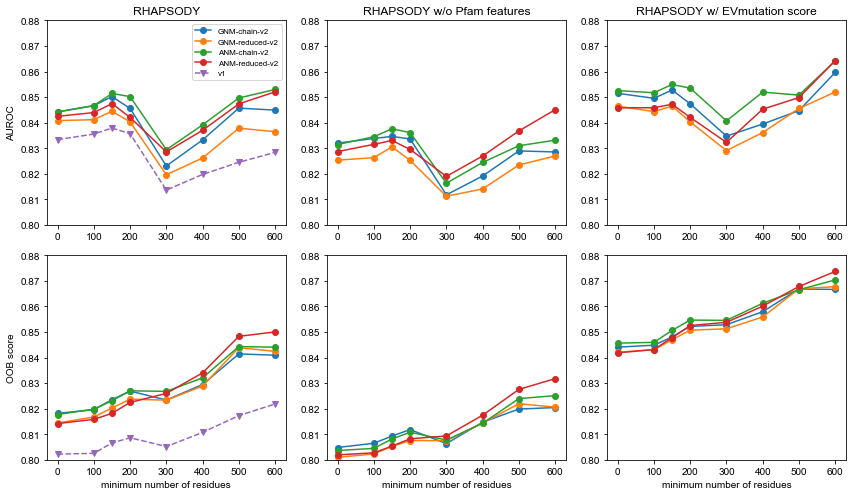

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(12,7))
fig.subplots_adjust(wspace=0.2)

ax[0,0].set_title('RHAPSODY')
ax[0,1].set_title('RHAPSODY w/o Pfam features')
ax[0,2].set_title('RHAPSODY w/ EVmutation score')
ax[0,0].set_ylabel('AUROC')
ax[1,0].set_ylabel('OOB score')
for j in range(3):
    ax[0,j].set_ylim([.80, .88])
    ax[1,j].set_ylim([.80, .88])
    ax[1,j].set_xlabel('minimum number of residues')

x = [0, 100, 150, 200, 300, 400, 500, 600]
for ENM in ['GNM', 'ANM']:
    for model in ['chain', 'reduced']:
        for i, version in enumerate(['v2', 'v2_noPfam', 'v2_EVmut']):
            scheme = f'{ENM}-{model}-{version}'
            AUC = [CV_summaries[f'{n}-{scheme}']['mean ROC-AUC'] for n in x]
            OOB = [CV_summaries[f'{n}-{scheme}']['mean OOB score'] for n in x]
            ax[0,i].plot(x, AUC, 'o-', label=scheme)
            ax[1,i].plot(x, OOB, 'o-', label=scheme)

AUC = [CV_summaries[f'{n}-v1']['mean ROC-AUC'] for n in x]
OOB = [CV_summaries[f'{n}-v1']['mean OOB score'] for n in x]
ax[0,0].plot(x, AUC, 'v--', label='v1')
ax[1,0].plot(x, OOB, 'v--', label='v1')

ax[0,0].legend(fontsize=8)

plt.tight_layout()
fig.savefig('figures/performances_comparison.png', dpi=300)

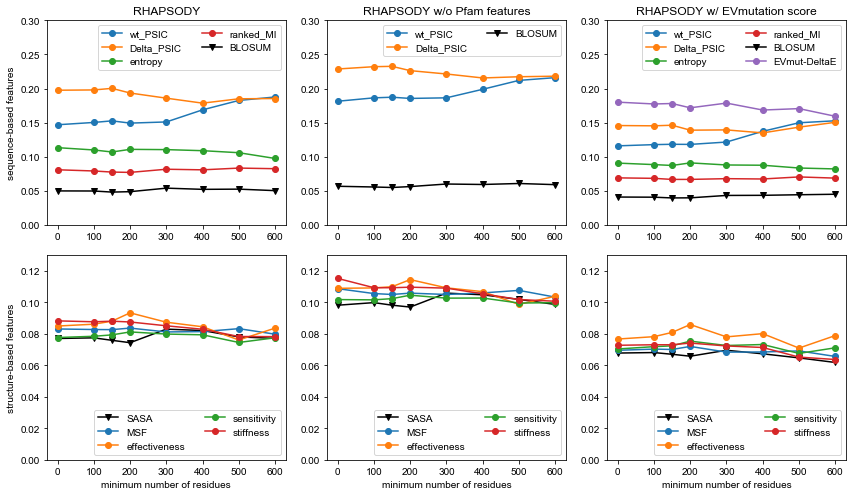

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
fig.subplots_adjust(wspace=0.2)

featsets = {}
featsets['v2'] = ['wt_PSIC', 'Delta_PSIC', 'SASA', 'MSF', 
                  'effectiveness', 'sensitivity', 'stiffness', 
                  'entropy', 'ranked_MI', 'BLOSUM']
featsets['v2_noPfam'] = ['wt_PSIC', 'Delta_PSIC', 'SASA', 'MSF', 
                         'effectiveness', 'sensitivity', 'stiffness', 'BLOSUM']
featsets['v2_EVmut'] = featsets['v2'] + ['EVmut-DeltaE',]
SEQ_feats = ['wt_PSIC', 'Delta_PSIC', 'BLOSUM', 'entropy', 'ranked_MI', 'EVmut-DeltaE']

ax[0,0].set_title('RHAPSODY')
ax[0,1].set_title('RHAPSODY w/o Pfam features')
ax[0,2].set_title('RHAPSODY w/ EVmutation score')
ax[0,0].set_ylabel('sequence-based features')
ax[1,0].set_ylabel('structure-based features')
for j in range(3):
    ax[0,j].set_ylim([0, .3])
    ax[1,j].set_ylim([0, .13])
    ax[1,j].set_xlabel('minimum number of residues')

x = [0, 100, 150, 200, 300, 400, 500, 600]

for i, (version, featset) in enumerate(featsets.items()):
    for j,f in enumerate(featset):
        ss = [CV_summaries[f'{n}-ANM-chain-{version}']['feat. importance'][j] for n in x]
        if f in ['BLOSUM', 'SASA']:
            m = 'kv-'
        else:
            m = 'o-'
        if f in SEQ_feats:
            ax[0,i].plot(x, ss, m, label=f)
        else:
            ax[1,i].plot(x, ss, m, label=f)
            
for a in ax[0]:
    a.legend(loc='upper right', ncol=2)
for a in ax[1]:
    a.legend(loc='lower right', ncol=2)

plt.tight_layout()
fig.savefig('figures/feat_imp_comparison.png', dpi=300)

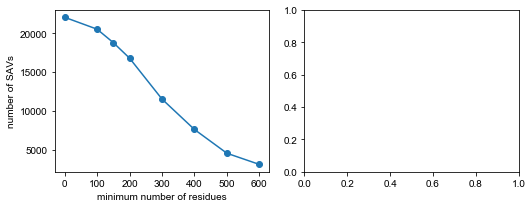

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5,3))
fig.subplots_adjust(wspace=0.2)

x = [0, 100, 150, 200, 300, 400, 500, 600]

y = np.array([CV_summaries[f'{n}-ANM-chain-v2']['dataset size'] for n in x])
ax1.plot(x, y, 'o-')
ax1.set_xlabel('minimum number of residues')
ax1.set_ylabel('number of SAVs')


# y2 = np.array([CV_summaries[f'{n}-ANM-chain-v2']['dataset bias'] for n in x])
# ax2.plot(x, y2, 'o-')
# ax2.set_xlabel('minimum number of residues')
# ax2.set_ylabel('fraction of del. SAVs')
# ax2.set_ylim((0.7, 0.78))

plt.tight_layout()
fig.savefig('figures/stats.png', dpi=300)